# Notebook Search

## Systematically finding computational notebooks by data journalists

GitHub hosts a wealth of resources for data journalists, including tools, tutorials, and computational notebooks detailing analysis used in published article. The abundance of public computational notebooks presents an opportunity to evaluate the kind of data wrangling processes data journalists are performing *in the wild* through qualitative analysis. 

This Jupyter notebook (running the Python 3 kernel) details the methods used to locate these computational notebooks used in open-coding.

In [1]:
import pandas as pd
import time, requests, os, yaml
from requests.auth import HTTPBasicAuth
import seaborn as sns
from IPython.display import display, clear_output, Markdown
pd.set_option("display.max_rows", None)  # Don't truncate rows when printing a Pandas DataFrame instance

%autosave 0

Autosave disabled


This notebook displays the results of many different kinds of search queries, so I output many of the results in Markdown for readability.

In [2]:
displayMarkdown = lambda md: display(Markdown(md))

getReposBySource = lambda src: repos[repos.source == src].sort_values(by='url')

urlToRow = lambda urls, s, k: [{'url': u, 'source': s, 'is_keeper': k} for u in urls]

def prompt(msg):
    clear_output(wait=True)
    displayMarkdown(msg)

### Querying the GitHub Search API

In the spirit of journalistic transparency, many data-journalism articles are published in conjunction with computational notebooks detailing the analysis steps. These notebooks are usually under source code management with git and pubically available as repositories, colloquially known as *repos*, on GitHub. The [GitHub Search API](https://developer.github.com/v3/search/) provies a convenient endpoint for unauthenticated, parameterized search across all user-uploaded repos on the site. To narrow-down results this notebook parameterizes search queires by tag and programming language. Many repos have user-defined keywords tagged with them to increase findability and discoverability on the site, and GitHub automatically analyzes the composition of programming languages used in a repo.

#### Rate-limiting requests

GitHub's API allows 60 unauthenticated requests per hour. So running this notebook straight through will eventually run up against the [rate limit](https://developer.github.com/v3/#rate-limiting), a 403 error. The `RateLimitError` class handles this case and exposes how many seconds remain until the rate-limit window resets. Many of the cells in this notebook will simply pause execution and wait how ever many seconds remain until the window resets. This notebook uses the [Freeze Jupyter Notebook extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/freeze/readme.html) to safeguard against cells making additional requests to the Search API after data has already been collected.

In [3]:
class RateLimitError(Exception):
    """A custom class for exception due to rate limiting
    
    Attributes:
        message: A human readable error message
        timeout: The number of seconds remaining until the current rate limit windows reset
    """
    
    def __init__(self, timeout):
        buffer = 5;  # add a buffer (in seconds) for safety
        self.timeout = round(int(timeout) - time.time(), 2) + buffer
        self.message = "🤦‍♀️ Hit GitHub's basic authentication the rate limit 🤦‍♂️\nWait {} seconds".format(self.timeout)

The snippet below will tell you if which kind of authentication you'll be using when making requests to GitHub's API. Adding credentials to `secrets.yaml` as shown below will allow for basic authentication, which has a 5,000 requests per hour limit.

In [4]:
rateLimitEndpoint = 'https://api.github.com/rate_limit'
secretsFile = 'secrets.yaml'
if os.path.exists(secretsFile):
    with open('secrets.yaml', 'r') as f:
        secrets = yaml.safe_load(f)
    username = secrets['github_auth']['username']
    password = secrets['github_auth']['password']    
    auth=HTTPBasicAuth(username, password)    
else:
    auth = None
    
r = requests.get(rateLimitEndpoint, auth=auth).json()
limit = r['resources']['core']['limit']

if limit == 5000:
    displayMarkdown('You\'ll be making basic authentication requests to GitHub\'s API')
elif limit == 60:
    displayMarkdown('You\'ll be making unauthnetication requests to GitHub\'s API')
else:
    displayMarkdown('Unknown authentication level. Limit is {}'.format(limit))

You'll be making basic authentication requests to GitHub's API

The `findRepos` function queries GitHub's Search API, formats the response to JSON, and raises an error if it hits the rate limit. It takes search parameters for the API as its arguments.

In [5]:
def pingGitHub(url):
    r = requests.get(url, auth=auth)
    if r.status_code == 403:
        raise RateLimitError(r.headers['x-ratelimit-reset'])
    elif r.status_code == 200:
        return r.json()
    else:
        return None

def findRepos(**kwargs):
    """ Make requests to GitHub's Search API 
        
        Returns the JSON response body as a dictionary
    """
    url = 'https://api.github.com/search/repositories?q='
    quantifiers = [ k + ':' + v for k, v in kwargs.items() ]
    url += '+'.join(quantifiers)
    res = pingGitHub(url)
    return res['items'] if res != None else []


The `org_blacklist` list contains exclude any repos by specific organizations from the results. The [*Los Angeles Times* Data Desk](https://github.com/datadesk) and [*BuzzFeed News*](https://github.com/buzzfeednews) were deliberately blacklisted from these results because both these organizations maintain an index of all the computational notebooks accompanying published articles. These repos will be integrated into the list later in this notebook.

In [6]:
languages = ['"jupyter%20notebook"', 'r', 'html']
tags = ['data-journalism', 'journalism']

The `repos` data frame will contain all the non-relevant repositories as well as the relevant repos used in further analysis.

In [7]:
repos = pd.DataFrame(columns=['url', 'source', 'is_keeper'])

### Searching for data journalism repos on GitHub

The code cell below queries the Search API for repos containing either the tag *journalism* or *data journalism* where the most majority programming language is *Jupyter Notebook*, *R*, or *HTML*. Although not all repos that are predominantly HTML code are computational notebooks, GitHub often classifies analysis performed primarily in an R Markdown file (.rmd) as HTML. Through my own unsystematic survey of this domain, I've found many notebooks from [*BuzzFeed News* from Peter Aldhous](https://github.com/BuzzFeedNews/2019-06-democratic-candidates-twitter) are programmed in R and tagged as HTML.

In [8]:
searchQueryCache = 'cache/tag_search.csv'
if not os.path.exists(searchQueryCache):
    queryResults = []
    for tag in tags:
        for lang in languages:
            is_success = False
            while not is_success:
                try:
                    res = findRepos(**{'topic': tag, 'language': lang })
                    for item in res:
                        repos = repos.append({
                            'url': item['html_url'],
                            'source': 'GitHub Search API',
                            'is_keeper': False
                        }, ignore_index=True)
                    is_success = True
                except RateLimitError as err:
                    print(err.message)
                    time.sleep(err.timeout)
    repos.drop_duplicates(subset=repos.columns[0], inplace=True)
    repos.to_csv(searchQueryCache, index=False)

In [9]:
repos = repos.append(pd.read_csv(searchQueryCache))
displayMarkdown('Querying the GitHub Search API returned {} potentially relevant repos:\n* {}'.format(repos.shape[0], '\n* '.join(repos.url)))

Querying the GitHub Search API returned 90 potentially relevant repos:
* https://github.com/datadesk/homeless-arrests-analysis
* https://github.com/datadesk/kobe-every-shot-ever
* https://github.com/datadesk/lapd-crime-classification-analysis
* https://github.com/datadesk/california-crop-production-wages-analysis
* https://github.com/datadesk/street-racing-analysis
* https://github.com/datadesk/california-electricity-capacity-analysis
* https://github.com/datadesk/california-fire-zone-analysis
* https://github.com/ONLPS/Datasets
* https://github.com/Caaddss/coda.br_workshop
* https://github.com/datadesk/california-h2a-visas-analysis
* https://github.com/datadesk/california-ccscore-analysis
* https://github.com/datastory-org/weekly-chart
* https://github.com/datadesk/helicopter-accident-analysis
* https://github.com/onyxfish/nicar-2017-agate
* https://github.com/datadesk/la-vacant-building-complaints-analysis
* https://github.com/datadesk/altair-election-maps-example
* https://github.com/croach/trump_voter_fraud_analysis
* https://github.com/datadesk/houston-flood-zone-analysis
* https://github.com/datadesk/ferc-enforcement-analysis
* https://github.com/datadesk/la-weedmaps-analysis
* https://github.com/jhroy/syllabus-EDM5240-H2019
* https://github.com/datadesk/la-settlements-analysis
* https://github.com/datadesk/california-k12-notebooks
* https://github.com/datadesk/california-kindergarten-vaccination-analysis
* https://github.com/annanorberg/eu-kandidater
* https://github.com/datadesk/tijuana-districts-map
* https://github.com/tortoisemedia-com/global-ai-index
* https://github.com/datadesk/altair-latimes
* https://github.com/datadesk/native-american-census-analysis
* https://github.com/Tahsin-Mayeesha/times-archive
* https://github.com/globeandmail/startr
* https://github.com/OpenDataCordoba/blogposts
* https://github.com/jadianes/data-journalism
* https://github.com/pippinlee/open-journalism-project
* https://github.com/brandonrobertz/autoscrape-py
* https://github.com/school-of-data/r-consortium-proposal
* https://github.com/cicadatatw/r-viz-workshop
* https://github.com/datadesk/construction-jobs-analysis
* https://github.com/datadesk/nyrb-covers-analysis
* https://github.com/datadesk/swana-census-analysis
* https://github.com/CodeForAfrica/LivingWage.KE
* https://github.com/jonasengelmann/Language-Analysis-of-Bundestags-Speeches
* https://github.com/CodeForAfrica/HealthTools.ZA-Ezolwaluko
* https://github.com/voltdatalab/atlas-noticia
* https://github.com/datadesk/hollister-ranch-analysis
* https://github.com/HussainAther/journalism
* https://github.com/hupili/djworkshop-cuc2018
* https://github.com/manuelvarzen/Vigia
* https://github.com/dannguyen/scrape-senate-financial-disclosures
* https://github.com/reale/wc
* https://github.com/N2ITN/are-you-fake-news
* https://github.com/datadesk/cpi
* https://github.com/neo4j-contrib/trumpworld-graph
* https://github.com/california-civic-data-coalition/first-python-notebook
* https://github.com/datadesk/altair-area-examples
* https://github.com/nilmolne/Text-Mining-The-New-York-Times-Articles
* https://github.com/datadesk/highschool-homicide-analysis
* https://github.com/TheOregonian/long-term-care-db
* https://github.com/lamthuyvo/cuny-advanced-data-journalism
* https://github.com/jfilter/masters-thesis
* https://github.com/datadesk/mlbcolors
* https://github.com/rOpenGov/rtimes
* https://github.com/GolemMediaGmbH/OfficeTemperatureData
* https://github.com/computer-assisted-reporting/NICAR18
* https://github.com/beecycles/Power_of_Irma
* https://github.com/beecycles/Endangered-Species-Act-Louisiana
* https://github.com/guardian/frontend
* https://github.com/wireservice/lookup
* https://github.com/securityfirst/Umbrella_content
* https://github.com/smach/R4JournalismBook
* https://github.com/PARINetwork/pari
* https://github.com/dailybruin/the-stack
* https://github.com/ireapps/first-graphics-app
* https://github.com/california-civic-data-coalition/californiacivicdata.org
* https://github.com/19hundreds/risks-workflow
* https://github.com/TheStatePress/SalaryList
* https://github.com/datadesk/responsive-fullscreen-header-example
* https://github.com/gabrielacaesar/contra-as-fake-news
* https://github.com/xinmeti/xinmeti.co
* https://github.com/formicablu/hearingvoices
* https://github.com/ANCIR/InvestigativeCenters.org
* https://github.com/profrobwells/Data-Analysis-Class-Jour-405v-5003
* https://github.com/meedan/montage-web
* https://github.com/Ohlasy/web
* https://github.com/vamind/terrific
* https://github.com/natlungfy/natlungfy.github.io
* https://github.com/xzzhang2/xzzhang2.github.io
* https://github.com/hackshackers/misinfocon-event-calendar
* https://github.com/ndarville/workfolio
* https://github.com/psolbach/xjournalism-data

The results above present only possible data sources worthy of further exploration. After a manual evaluation of the contents of each repository, only the following notebooks contained valid data journalism workflows. Results from the *Los Angeles Times*, from the DataDesk organization, are intentionally excluded at this stage of data collection. This newspaper keeps a [special index repo](https://github.com/datadesk/notebooks) that links too all computational notebooks used by reporters and will be scraped individually.

In [10]:
keepers = [
    'https://github.com/Tahsin-Mayeesha/times-archive',
    'https://github.com/TheOregonian/long-term-care-db',
    'https://github.com/beecycles/Endangered-Species-Act-Louisiana',
    'https://github.com/beecycles/Power_of_Irma',
    'https://github.com/datastory-org/weekly-chart',
]

repos.loc[repos['url'].isin(keepers), 'is_keeper'] = True
repos[repos.is_keeper == True]

,url,source,is_keeper
11,https://github.com/datastory-org/weekly-chart,GitHub Search API,True
29,https://github.com/Tahsin-Mayeesha/times-archive,GitHub Search API,True
57,https://github.com/TheOregonian/long-term-care-db,GitHub Search API,True
64,https://github.com/beecycles/Power_of_Irma,GitHub Search API,True
65,https://github.com/beecycles/Endangered-Specie...,GitHub Search API,True


### Scraping index repos

Two news organizations, the *Los Angeles Times* and *BuzzFeed News* keep a centralized repository of links to other computational notebook repositories used with their reporting. These two repos includes notebooks that did not get returned in the search query above because they do not have tags.

Including the latest commit ID in the raw URL to `notebooks.csv` ensures that results from the bash command below only return notebooks published at the time of my analysis, May 26, 2019. GitHub has a few [hidden features for permenant links](https://help.github.com/en/articles/getting-permanent-links-to-files).

#### Notebooks from the *Los Angles Times*

The [*LA Times* notebook repository](https://github.com/datadesk/notebooks) has a table coded in markdown with the date, URL, and description of each published computational notebook.

In [11]:
laTimesSource = 'LA Times Index Repo'
latimes = ! mkdir -p notebooks/la_times \
&& cd notebooks/la_times \
&& curl -s "https://raw.githubusercontent.com/datadesk/notebooks/d0fea75950b7911d37cd5c2fc1995da498f3d494/notebooks.csv" \
| awk -F ',' '{print $4}' \
| tail -n +2

repos = repos.append(urlToRow(latimes, laTimesSource, True), ignore_index=True)

# Some LA Times repos were identified in the GitHub Search API query
repos.drop_duplicates(subset='url', inplace=True)

newRepos = getReposBySource(laTimesSource)
displayMarkdown('Retrieved {} additional, relevant repos from *Los Angeles Times*:\n\n * {}'.format(newRepos.shape[0], '\n * '.join(newRepos.url)))

Retrieved 6 additional, relevant repos from *Los Angeles Times*:

 * https://github.com/datadesk/census-hard-to-map-analysis
 * https://github.com/datadesk/deleon-district-election-results-analysis
 * https://github.com/datadesk/hsr-document-analysis
 * https://github.com/kyleykim/R_Scripts/tree/master/la-me-ln-california-fire-aircraft-delay
 * https://github.com/kyleykim/R_Scripts/tree/master/la-me-ln-hhh-unequal
 * https://github.com/ryanvmenezes/lawlers-law

#### Notebooks from *BuzzFeed News*

*BuzzFeed News* also has [a central repository](https://github.com/BuzzFeedNews/everything) containing a single markdown document that serves as an index for all their computational notebooks on GitHub. It's burried in the repo's `README.md`, but still accessable with grep. Most of these repos do not have keyword tags and were not caught in the initial query to the Search API.

In [12]:
buzzfeedSource = 'BuzzFeed Index Repo'

# Get URLs for all BuzzFeed's computational notebooks
buzzfeedRepos = ! curl -s "https://raw.githubusercontent.com/BuzzFeedNews/everything/a2cbcc78ef67322a8443553645f85e6b310e658c/README.md" \
| grep "\[:link:\]" \
| grep -E -o "https:\/\/github\.com\/BuzzFeedNews\/[^\)]+"

# Append new repos to master list
repos = repos.append(urlToRow(buzzfeedRepos, buzzfeedSource, True), ignore_index=True) \
    .drop_duplicates(subset='url')  # There aren't any duplicates, but I'll dedupe anyway

newRepos = getReposBySource(buzzfeedSource)
displayMarkdown('The index repo from *BuzzFeed News* added {} new, relevant repos:\n\n * {}'.format(newRepos.shape[0], '\n * '.join(newRepos.url)))

The index repo from *BuzzFeed News* added 81 new, relevant repos:

 * https://github.com/BuzzFeedNews/2014-06-bikeshare-gender-maps
 * https://github.com/BuzzFeedNews/2014-06-firework-injuries
 * https://github.com/BuzzFeedNews/2014-08-irs-scams
 * https://github.com/BuzzFeedNews/2014-08-st-louis-county-segregation
 * https://github.com/BuzzFeedNews/2014-09-rising-sunday-show-guests
 * https://github.com/BuzzFeedNews/2014-09-tuition-and-minimum-wage
 * https://github.com/BuzzFeedNews/2015-02-georgia-cpa-scores
 * https://github.com/BuzzFeedNews/2015-02-texas-cpa-deficiencies
 * https://github.com/BuzzFeedNews/2015-03-earthquake-maps
 * https://github.com/BuzzFeedNews/2015-05-talkpay-tweets
 * https://github.com/BuzzFeedNews/2015-06-ssm-and-abortion-poll
 * https://github.com/BuzzFeedNews/2015-07-h2-visas-and-enforcement
 * https://github.com/BuzzFeedNews/2015-07-primates
 * https://github.com/BuzzFeedNews/2015-08-immigrant-detention
 * https://github.com/BuzzFeedNews/2015-10-walker-donors
 * https://github.com/BuzzFeedNews/2015-11-lottery-simulations
 * https://github.com/BuzzFeedNews/2015-11-refugees-in-the-united-states
 * https://github.com/BuzzFeedNews/2015-12-H-2-visas-and-experience-requirements
 * https://github.com/BuzzFeedNews/2015-12-fatal-police-shootings
 * https://github.com/BuzzFeedNews/2015-12-mass-shooting-intervals
 * https://github.com/BuzzFeedNews/2015-12-the-coyote
 * https://github.com/BuzzFeedNews/2016-01-immigrant-detention-india
 * https://github.com/BuzzFeedNews/2016-01-port-arthur-arrests
 * https://github.com/BuzzFeedNews/2016-01-tennis-betting-analysis
 * https://github.com/BuzzFeedNews/2016-01-texas-municipal-courts
 * https://github.com/BuzzFeedNews/2016-02-republican-donor-movements
 * https://github.com/BuzzFeedNews/2016-04-bernie-sanders-donors
 * https://github.com/BuzzFeedNews/2016-04-federal-surveillance-planes
 * https://github.com/BuzzFeedNews/2016-04-republican-donor-movements
 * https://github.com/BuzzFeedNews/2016-05-H-2-debarments-and-violations
 * https://github.com/BuzzFeedNews/2016-07-athletic-performances
 * https://github.com/BuzzFeedNews/2016-07-rnc-dnc-surveillance-planes
 * https://github.com/BuzzFeedNews/2016-08-sports-gender-gaps
 * https://github.com/BuzzFeedNews/2016-09-shy-trumpers
 * https://github.com/BuzzFeedNews/2016-09-ucr-analysis
 * https://github.com/BuzzFeedNews/2016-10-facebook-fact-check
 * https://github.com/BuzzFeedNews/2016-10-tech-campaign-contributions
 * https://github.com/BuzzFeedNews/2016-10-white-ancestry-and-trump-support
 * https://github.com/BuzzFeedNews/2016-11-bellwether-counties
 * https://github.com/BuzzFeedNews/2016-11-grading-the-election-forecasts
 * https://github.com/BuzzFeedNews/2016-11-voter-power-by-demographic
 * https://github.com/BuzzFeedNews/2016-12-fake-news-survey
 * https://github.com/BuzzFeedNews/2016-12-inpatient-discharge-analysis
 * https://github.com/BuzzFeedNews/2016-12-medicare-claims-analysis
 * https://github.com/BuzzFeedNews/2016-12-river-point-involuntary-commitment-petitions
 * https://github.com/BuzzFeedNews/2016-12-transgender-rights-survey
 * https://github.com/BuzzFeedNews/2016-12-warmest-year
 * https://github.com/BuzzFeedNews/2017-01-causes-of-warming
 * https://github.com/BuzzFeedNews/2017-01-immigration-and-science
 * https://github.com/BuzzFeedNews/2017-01-media-platform-and-news-trust-survey
 * https://github.com/BuzzFeedNews/2017-04-fake-news-ad-trackers
 * https://github.com/BuzzFeedNews/2017-05-us-health-care
 * https://github.com/BuzzFeedNews/2017-07-doj-gs-15
 * https://github.com/BuzzFeedNews/2017-08-harvey-emissions-reports
 * https://github.com/BuzzFeedNews/2017-08-partisan-sites-and-facebook-pages
 * https://github.com/BuzzFeedNews/2017-08-spy-plane-finder
 * https://github.com/BuzzFeedNews/2017-09-federal-employee-departure-rates
 * https://github.com/BuzzFeedNews/2017-09-harvey-emissions-update
 * https://github.com/BuzzFeedNews/2017-09-science-foia
 * https://github.com/BuzzFeedNews/2017-11-federal-employee-diversity
 * https://github.com/BuzzFeedNews/2017-11-gun-sales-estimates
 * https://github.com/BuzzFeedNews/2017-12-eeoc-harassment-charges/
 * https://github.com/BuzzFeedNews/2017-12-fake-news-top-50
 * https://github.com/BuzzFeedNews/2017-12-sexual-misconduct-cable-news-coverage
 * https://github.com/BuzzFeedNews/2018-01-trump-state-of-the-union
 * https://github.com/BuzzFeedNews/2018-01-trump-twitter-wars
 * https://github.com/BuzzFeedNews/2018-01-twitter-withheld-accounts
 * https://github.com/BuzzFeedNews/2018-02-figure-skating-analysis
 * https://github.com/BuzzFeedNews/2018-02-olympic-figure-skating-analysis
 * https://github.com/BuzzFeedNews/2018-03-oscars-script-diversity-analysis
 * https://github.com/BuzzFeedNews/2018-05-fentanyl-and-cocaine-overdose-deaths
 * https://github.com/BuzzFeedNews/2018-06-nyc-311-complaints-and-gentrification
 * https://github.com/BuzzFeedNews/2018-07-ofsted-inspections
 * https://github.com/BuzzFeedNews/2018-08-charlottesville-twitter-trolls
 * https://github.com/BuzzFeedNews/2018-09-ftc-analysis
 * https://github.com/BuzzFeedNews/2018-10-midterm-demographics
 * https://github.com/BuzzFeedNews/2018-10-russian-troll-tweets
 * https://github.com/BuzzFeedNews/2018-12-fake-news-top-50
 * https://github.com/BuzzFeedNews/2018-12-wechat-pence/
 * https://github.com/BuzzFeedNews/2019-04-democratic-candidate-codonors
 * https://github.com/BuzzFeedNews/presidential-language-notebooks

### Organizations monitored by @NewsNerdRepos Twitter bot

Since June 2016, the Twitter bot [@newsnerdbot](https://twitter.com/newsnerdbot) monitors a currated list of newsrooms and independent journalism organizations on GitHub. Since this list of GitHub organizations is also a repo, I've added it as a submodule to this analysis repo.

In [13]:
orgs = ! cat "open-journalism/README.md" \
| grep -E -o "https://github.com/[^\)]+" \
| grep -E -o "[^\/$]+$"

items = '\n * '.join(['https://github.com/' + o for o in orgs])
displayMarkdown('There are {} organizations monitored by @newsnerdbot \n\n * {}'.format(len(orgs), items))

There are 238 organizations monitored by @newsnerdbot 

 * https://github.com/abcnews
 * https://github.com/theadvocate
 * https://github.com/ajam
 * https://github.com/ALJAZEERAPLUS
 * https://github.com/ajinteractive
 * https://github.com/APMG
 * https://github.com/arizonadailystar
 * https://github.com/associatedpress
 * https://github.com/NewsappAJC
 * https://github.com/theatlantic
 * https://github.com/statesman
 * https://github.com/axioscode
 * https://github.com/baltimore-sun-data
 * https://github.com/bangordailynews
 * https://github.com/baycitizen
 * https://github.com/bbc-data-unit
 * https://github.com/BBC-News
 * https://github.com/BBC-News-Labs
 * https://github.com/bbcvisualjournalism
 * https://github.com/berlinermorgenpost
 * https://github.com/bloomberg
 * https://github.com/bloomberggraphics
 * https://github.com/bloombergmedia
 * https://github.com/bvisualdata
 * https://github.com/bostonglobe
 * https://github.com/thebuffalonews
 * https://github.com/BuzzFeed
 * https://github.com/BuzzFeedNews
 * https://github.com/buzzfeed-openlab
 * https://github.com/cbcrc
 * https://github.com/CBCNews
 * https://github.com/publici
 * https://github.com/Chalkbeat
 * https://github.com/postandcourier
 * https://github.com/thechicagoreporter
 * https://github.com/newsapps
 * https://github.com/chrondata
 * https://github.com/civio
 * https://github.com/condenast
 * https://github.com/correctiv
 * https://github.com/dailybeast
 * https://github.com/dailyherald
 * https://github.com/MailOnline
 * https://github.com/dallasmorningnews
 * https://github.com/dandc
 * https://github.com/denverpost
 * https://github.com/thunderdome-data
 * https://github.com/DNAinfo
 * https://github.com/dowjones
 * https://github.com/dukechronicle
 * https://github.com/economist-data-team
 * https://github.com/economistdigitalsolutions
 * https://github.com/the-economist-editorial
 * https://github.com/economist-components
 * https://github.com/el-faro
 * https://github.com/financial-times
 * https://github.com/ForeignPolicy
 * https://github.com/frontlinepbs
 * https://github.com/ftchinese
 * https://github.com/ftc-editorial
 * https://github.com/ftlabs
 * https://github.com/firstlookmedia
 * https://github.com/fivethirtyeight
 * https://github.com/GannettDigital
 * https://github.com/gawkermedia
 * https://github.com/GMG-Special-Projects-Desk
 * https://github.com/guardian
 * https://github.com/gdnmobilelab
 * https://github.com/Haaretz
 * https://github.com/hartfordcourant
 * https://github.com/HBRGTech
 * https://github.com/HearstCorp
 * https://github.com/Hearst-DD
 * https://github.com/Hearst-Hatchery
 * https://github.com/HindustanTimesLabs
 * https://github.com/houstonchronicle
 * https://github.com/houston-chronicle
 * https://github.com/huffpostdata
 * https://github.com/icij
 * https://github.com/initiumlab
 * https://github.com/InsideEnergy
 * https://github.com/the-irish-times
 * https://github.com/lohud
 * https://github.com/pjstar
 * https://github.com/SCPR
 * https://github.com/kqed
 * https://github.com/lanacioncom
 * https://github.com/nacion
 * https://github.com/laopinion
 * https://github.com/lemonde
 * https://github.com/labsletemps
 * https://github.com/thelens
 * https://github.com/liberation
 * https://github.com/datadesk
 * https://github.com/courierjournal
 * https://github.com/themarshallproject
 * https://github.com/mashable
 * https://github.com/mcclatchy
 * https://github.com/miamiherald
 * https://github.com/micnews
 * https://github.com/datahub
 * https://github.com/minneapolisstartribune
 * https://github.com/striblab
 * https://github.com/minnpost
 * https://github.com/mirror-media
 * https://github.com/motherjones
 * https://github.com/natgeo
 * https://github.com/natgeosociety
 * https://github.com/nbcnews
 * https://github.com/newscientistapps
 * https://github.com/nydailynews
 * https://github.com/nymag
 * https://github.com/newyorkpost
 * https://github.com/NYTimes
 * https://github.com/newsdev
 * https://github.com/nytlabs
 * https://github.com/theupshot
 * https://github.com/newyorker
 * https://github.com/delawaredata
 * https://github.com/newsday
 * https://github.com/newsweek
 * https://github.com/npr
 * https://github.com/nprapps
 * https://github.com/nzzdev
 * https://github.com/theonion
 * https://github.com/OrlandoSentinel
 * https://github.com/PalmBeachPost
 * https://github.com/newshour
 * https://github.com/phillymedia
 * https://github.com/pitchfork
 * https://github.com/the-politico
 * https://github.com/polygraph-cool
 * https://github.com/TheOregonian
 * https://github.com/oregonian
 * https://github.com/propublica
 * https://github.com/publicsource
 * https://github.com/PRX
 * https://github.com/quartz
 * https://github.com/quartz-bot-studio
 * https://github.com/rferl
 * https://github.com/registerguard
 * https://github.com/twreporter
 * https://github.com/thomsonreuters
 * https://github.com/cirlabs
 * https://github.com/PostDispatchInteractive
 * https://github.com/stlpublicradio
 * https://github.com/sacbee
 * https://github.com/sltrib
 * https://github.com/sa-express-news
 * https://github.com/sfchronicle
 * https://github.com/seattletimes
 * https://github.com/slategroup
 * https://github.com/SunSentinel
 * https://github.com/SpokesmanReview
 * https://github.com/sueddeutsche
 * https://github.com/tageswoche
 * https://github.com/tbtimes
 * https://github.com/telegraph
 * https://github.com/telemundo
 * https://github.com/texastribune
 * https://github.com/texty
 * https://github.com/TimeMagazine
 * https://github.com/times
 * https://github.com/times-machine
 * https://github.com/globeandmail
 * https://github.com/trendct
 * https://github.com/tribune
 * https://github.com/usatoday
 * https://github.com/usatoday-smb
 * https://github.com/vprnet
 * https://github.com/virginianpilot
 * https://github.com/voanews
 * https://github.com/voxmedia
 * https://github.com/WSJ
 * https://github.com/washingtoncitypaper
 * https://github.com/washingtonpost
 * https://github.com/washingtonpost-archive
 * https://github.com/wpinvestigative
 * https://github.com/wapopartners
 * https://github.com/washingtontimes
 * https://github.com/wbez
 * https://github.com/LearningLab
 * https://github.com/wbur
 * https://github.com/WGBH
 * https://github.com/datanews
 * https://github.com/wnyc
 * https://github.com/wraldata
 * https://github.com/Yleisradio
 * https://github.com/youthradio
 * https://github.com/ZeitOnline
 * https://github.com/accurat
 * https://github.com/california-civic-data-coalition
 * https://github.com/CALmatters
 * https://github.com/censusreporter
 * https://github.com/City-Bureau
 * https://github.com/civica-digital
 * https://github.com/cunyjschool
 * https://github.com/coralproject
 * https://github.com/datamade
 * https://github.com/datawrapper
 * https://github.com/documentcloud
 * https://github.com/enigma-io
 * https://github.com/everyblock
 * https://github.com/freedomofpress
 * https://github.com/FullFact
 * https://github.com/open-journalism
 * https://github.com/googletrends
 * https://github.com/govtrack
 * https://github.com/indiaspend
 * https://github.com/hackshackers
 * https://github.com/inn
 * https://github.com/icfj-org
 * https://github.com/internews-ke
 * https://github.com/invinst
 * https://github.com/ireapps
 * https://github.com/jplusplus
 * https://github.com/kiln
 * https://github.com/meedan
 * https://github.com/newsappsio
 * https://github.com/newslynx
 * https://github.com/niemanlab
 * https://github.com/NUKnightLab
 * https://github.com/openelections
 * https://github.com/openNews
 * https://github.com/opennewslabs
 * https://github.com/openstates
 * https://github.com/overview
 * https://github.com/PitchInteractiveInc
 * https://github.com/poderopedia
 * https://github.com/politibot
 * https://github.com/policymic
 * https://github.com/povdocs
 * https://github.com/reesenewslab
 * https://github.com/sourcefabric
 * https://github.com/spiritedmedia
 * https://github.com/sunlightlabs
 * https://github.com/tarbell-project
 * https://github.com/wireservice

The cell below searches earch organization listed above for repos with a primary language commonly used in computational notebooks: Jupyter Notebook, R, or HTML. Using unauthenticated requests, this process can take more than an hour to complete.

In [14]:
newsNerdSource = '@newsnerdrepos'
newsnerdrepos_fn = 'cache/newsnerdrepos.csv';

if not os.path.exists(newsnerdrepos_fn):
    n = len(orgs)
    newsNerdRepos = []
    while len(orgs) > 0:
        org = orgs.pop()
        i = 0
        while i < len(languages):
            lang = languages[i]
            is_success = False
            while not is_success:
                try:
                    res = findRepos(**{ 'org': org, 'language': lang })
                    newsNerdNepos += [ repo['html_url'] for repo in res if repo['owner']['login'] ]
                    i += 1
                    is_success = True
                except RateLimitError as err:
                    prompt('{}\n{}% of orgs remaining'.format(err.message, (round((len(orgs) / n) * 100))))
                    time.sleep(err.timeout)
    pd.DataFrame(newNerdRepos).to_csv(newsnerdrepos_fn, index=False)

In [15]:
newsNerdRepos = list(pd.read_csv(newsnerdrepos_fn)['0'])
repos = repos.append([{
    'url': url,
    'source': newsNerdSource,
    'is_keeper': False } for url in newsNerdRepos ], ignore_index=True) \
    .drop_duplicates(subset='url')

newRepos = getReposBySource(newsNerdSource)
displayMarkdown('Querying the Search API with @newsNerdRepos organizations yielded {} new, potentially-relevant repos:\n * {}'.format(newRepos.shape[0], '\n * '.join(newRepos.url)))

Querying the Search API with @newsNerdRepos organizations yielded 1095 new, potentially-relevant repos:
 * https://github.com/AJInteractive/44-45
 * https://github.com/AJInteractive/Batcave_Bootstrap_Starterkit
 * https://github.com/AJInteractive/GoogleTrendsPalestineIsrael
 * https://github.com/AJInteractive/guns2012
 * https://github.com/AJInteractive/palestineremix-search
 * https://github.com/AJInteractive/palestineremix-video
 * https://github.com/BBC-Data-Unit/cervical-screening
 * https://github.com/BBC-Data-Unit/council-cuts-charts
 * https://github.com/BBC-Data-Unit/council-reserves
 * https://github.com/BBC-Data-Unit/deprivation-premature-deaths
 * https://github.com/BBC-Data-Unit/electric-car-charging-points
 * https://github.com/BBC-Data-Unit/eu-elections-2019
 * https://github.com/BBC-Data-Unit/internal-migration-london
 * https://github.com/BBC-Data-Unit/midwife-led-units
 * https://github.com/BBC-Data-Unit/rail-fare-increases-2019
 * https://github.com/BBC-Data-Unit/unused
 * https://github.com/BBC-News-Labs/bbcnewslabs-internal-bootstrap
 * https://github.com/BBC-News-Labs/docs
 * https://github.com/BBC-News-Labs/mp-linked-data
 * https://github.com/BBC-News-Labs/saved-reading
 * https://github.com/BBC-News/accessibility-news-and-you
 * https://github.com/BBC-News/news-app-public
 * https://github.com/BBCVisualJournalism/data-table-trainee-assessment
 * https://github.com/BBCVisualJournalism/newsspec_6761
 * https://github.com/BBCVisualJournalism/newsspec_6762
 * https://github.com/BBCVisualJournalism/newsspec_6925
 * https://github.com/BBCVisualJournalism/nhs_winter_data
 * https://github.com/BloombergGraphics/2017-health-insurer-exits-data
 * https://github.com/BloombergGraphics/2017-trump-llc-documents
 * https://github.com/BloombergGraphics/2017-wmata-ridership-data
 * https://github.com/BostonGlobe/02-23-2015_bondbill
 * https://github.com/BostonGlobe/03-01-2015-boom
 * https://github.com/BostonGlobe/2015-09-28_huts
 * https://github.com/BostonGlobe/2015-10-01_amp
 * https://github.com/BostonGlobe/2015-10-14_deer
 * https://github.com/BostonGlobe/2016-01-27_keolis-delays
 * https://github.com/BostonGlobe/2016-02-08_snowfall_map
 * https://github.com/BostonGlobe/2016_delegate_tracker
 * https://github.com/BostonGlobe/alcohol-graphic
 * https://github.com/BostonGlobe/boston-revealed
 * https://github.com/BostonGlobe/boston-rocks
 * https://github.com/BostonGlobe/brief
 * https://github.com/BostonGlobe/chinatown
 * https://github.com/BostonGlobe/death
 * https://github.com/BostonGlobe/fluMap
 * https://github.com/BostonGlobe/generator-globeproject
 * https://github.com/BostonGlobe/gpreview
 * https://github.com/BostonGlobe/icerinks
 * https://github.com/BostonGlobe/liquor-licenses
 * https://github.com/BostonGlobe/liquor-licenses-2
 * https://github.com/BostonGlobe/maintenance
 * https://github.com/BostonGlobe/potholes
 * https://github.com/BostonGlobe/potholes18
 * https://github.com/BostonGlobe/schoolbuses
 * https://github.com/BostonGlobe/scribblelive_widget
 * https://github.com/BostonGlobe/snowfall-totals
 * https://github.com/BostonGlobe/spotlight-mental-health
 * https://github.com/BostonGlobe/stateparks
 * https://github.com/BostonGlobe/trump-transcripts
 * https://github.com/BostonGlobe/tsarnaev-cards
 * https://github.com/BostonGlobe/weather-distributions
 * https://github.com/BuzzFeedNews/2016-11-philadelphia-turnout
 * https://github.com/BuzzFeedNews/2017-12-eeoc-harassment-charges
 * https://github.com/BuzzFeedNews/2018-07-wildfire-trends
 * https://github.com/BuzzFeedNews/2018-12-wechat-pence
 * https://github.com/BuzzFeedNews/2019-04-climate-change
 * https://github.com/BuzzFeedNews/2019-06-democratic-candidates-twitter
 * https://github.com/BuzzFeedNews/us-land-cover
 * https://github.com/BuzzFeedNews/whtranscripts
 * https://github.com/City-Bureau/chi-2019-runoff-maps
 * https://github.com/City-Bureau/documenters-map
 * https://github.com/City-Bureau/elections-2019-map
 * https://github.com/City-Bureau/field-guide
 * https://github.com/DallasMorningNews/flask-pullquote
 * https://github.com/DallasMorningNews/interactive_buz
 * https://github.com/DallasMorningNews/interactive_concussions
 * https://github.com/DallasMorningNews/interactive_cowboys-gameday-2016
 * https://github.com/DallasMorningNews/interactive_dixon-circle
 * https://github.com/DallasMorningNews/interactive_healthcare-crossroads
 * https://github.com/DallasMorningNews/interactive_new-moms
 * https://github.com/DallasMorningNews/interactive_ninos-migrantes
 * https://github.com/DallasMorningNews/interactives_starterkit
 * https://github.com/DallasMorningNews/nicar-d3-2017
 * https://github.com/DallasMorningNews/photoTemplate
 * https://github.com/DallasMorningNews/pulitzer
 * https://github.com/EconomistDigitalSolutions/goberry
 * https://github.com/FTChinese/AdTemplates
 * https://github.com/FTChinese/FTCAndroid
 * https://github.com/FTChinese/FTCCApp-iOS
 * https://github.com/FTChinese/FTChinese.github.io
 * https://github.com/FTChinese/NEXT
 * https://github.com/FTChinese/NewFTCApp-iOS
 * https://github.com/FTChinese/ThirdPartyAd
 * https://github.com/FTChinese/Web-NewFTCiPhone
 * https://github.com/FTChinese/ad-management
 * https://github.com/FTChinese/ad-page
 * https://github.com/FTChinese/chart
 * https://github.com/FTChinese/charts
 * https://github.com/FTChinese/ebook
 * https://github.com/FTChinese/ebook-new
 * https://github.com/FTChinese/ftacademy
 * https://github.com/FTChinese/ftacademy-node
 * https://github.com/FTChinese/ftc-android-kotlin
 * https://github.com/FTChinese/ftcpage
 * https://github.com/FTChinese/ftcwebapp
 * https://github.com/FTChinese/iPhoneApp
 * https://github.com/FTChinese/webapp
 * https://github.com/FTChinese/webapp-v2
 * https://github.com/Financial-Times/alphaville-footer
 * https://github.com/Financial-Times/alphaville-ui
 * https://github.com/Financial-Times/assanka.net
 * https://github.com/Financial-Times/author-alerts
 * https://github.com/Financial-Times/comphubvids
 * https://github.com/Financial-Times/crm-meme-templates
 * https://github.com/Financial-Times/data
 * https://github.com/Financial-Times/ft-branded-content
 * https://github.com/Financial-Times/ft-origami
 * https://github.com/Financial-Times/ftRtools
 * https://github.com/Financial-Times/g-simplequiz
 * https://github.com/Financial-Times/g-ui
 * https://github.com/Financial-Times/hackathon-2016-team-elm
 * https://github.com/Financial-Times/list-concepts-timelines
 * https://github.com/Financial-Times/n-internal-tool
 * https://github.com/Financial-Times/n-invite-colleagues
 * https://github.com/Financial-Times/n-messaging-client
 * https://github.com/Financial-Times/n-syn-footer
 * https://github.com/Financial-Times/n-syn-header
 * https://github.com/Financial-Times/o-business-card
 * https://github.com/Financial-Times/o-ft-buttons
 * https://github.com/Financial-Times/o-ft-footer
 * https://github.com/Financial-Times/o-ft-header
 * https://github.com/Financial-Times/o-header--theme-ic
 * https://github.com/Financial-Times/o-timeline
 * https://github.com/Financial-Times/o-tweet
 * https://github.com/Financial-Times/o-type
 * https://github.com/Financial-Times/origami
 * https://github.com/Financial-Times/responsive-image-proxy-helper
 * https://github.com/Financial-Times/shorthand-lambda
 * https://github.com/Financial-Times/timesheet-bot
 * https://github.com/Financial-Times/ui-style-guide
 * https://github.com/GMG-Special-Projects-Desk/fares.jalopnik
 * https://github.com/GMG-Special-Projects-Desk/pymk-inspector
 * https://github.com/GannettDigital/GannettAdKit
 * https://github.com/GannettDigital/LIDtool
 * https://github.com/GannettDigital/spark-sign-up
 * https://github.com/GoogleTrends/GOPDebate1
 * https://github.com/GoogleTrends/GOPHorseRace
 * https://github.com/GoogleTrends/SLElections
 * https://github.com/GoogleTrends/brussels-attacks
 * https://github.com/GoogleTrends/chord_diagram
 * https://github.com/GoogleTrends/collapsible_tree
 * https://github.com/GoogleTrends/crosscheck-dashboard-fr
 * https://github.com/GoogleTrends/demcands1
 * https://github.com/GoogleTrends/demcands_tree
 * https://github.com/GoogleTrends/google_oscars
 * https://github.com/GoogleTrends/gop_tree
 * https://github.com/GoogleTrends/independence-day-traffic
 * https://github.com/GoogleTrends/indicators
 * https://github.com/GoogleTrends/languages
 * https://github.com/GoogleTrends/mappingthanksgiving
 * https://github.com/GoogleTrends/olympics
 * https://github.com/GoogleTrends/oscars_2018
 * https://github.com/GoogleTrends/oscars_2018_embed
 * https://github.com/GoogleTrends/parisattacks
 * https://github.com/GoogleTrends/search-senators-2017
 * https://github.com/GoogleTrends/search-tvshows-2017
 * https://github.com/GoogleTrends/sotu_2019
 * https://github.com/GoogleTrends/sotu_2019_state
 * https://github.com/GoogleTrends/sotu_2019_year
 * https://github.com/GoogleTrends/tilemaps
 * https://github.com/GoogleTrends/tilemaps-france
 * https://github.com/GoogleTrends/traveltrends
 * https://github.com/GoogleTrends/world-cup-2018
 * https://github.com/GoogleTrends/youtubethanksgiving
 * https://github.com/GoogleTrends/zikasearch
 * https://github.com/HearstCorp/jiracards
 * https://github.com/HindustanTimesLabs/brahmaputra-floods
 * https://github.com/HindustanTimesLabs/budget-schemes-2018
 * https://github.com/HindustanTimesLabs/chennai-oil-spill
 * https://github.com/HindustanTimesLabs/communal-mlas-list
 * https://github.com/HindustanTimesLabs/data-fellowship-2018
 * https://github.com/HindustanTimesLabs/evil-twitter-feed
 * https://github.com/HindustanTimesLabs/ipl-ranks-history
 * https://github.com/HindustanTimesLabs/mplad-spending
 * https://github.com/HindustanTimesLabs/mps-attendance-education-crime
 * https://github.com/HindustanTimesLabs/ms-subbulakshmi-carnatic-rockstar
 * https://github.com/HindustanTimesLabs/padma-stream-graph
 * https://github.com/HindustanTimesLabs/union-budget-2016
 * https://github.com/HindustanTimesLabs/uri-in-context
 * https://github.com/HindustanTimesLabs/us-elections-indian-americans
 * https://github.com/HindustanTimesLabs/were-hiring
 * https://github.com/HindustanTimesLabs/women-candidates-himachal
 * https://github.com/Houston-Chronicle/2018-local-results
 * https://github.com/Houston-Chronicle/2018-regional-ballot
 * https://github.com/Houston-Chronicle/2018-voter-guide
 * https://github.com/Houston-Chronicle/flood-bonds-2018
 * https://github.com/Houston-Chronicle/top100
 * https://github.com/ICIJ/icij-discourse-projects-addon
 * https://github.com/ICIJ/icij-discourse-projects-banner
 * https://github.com/INN/one-liner
 * https://github.com/InsideEnergy/Data-for-stories
 * https://github.com/InsideEnergy/TX-flsa-lawsuits
 * https://github.com/MailOnline/gargamel
 * https://github.com/MailOnline/msn_feed_samples
 * https://github.com/MiamiHerald/elex2016homepage
 * https://github.com/MinnPost/minnpost-2015-eoy-report
 * https://github.com/MinnPost/minnpost-districts-to-watch-2016
 * https://github.com/MinnPost/minnpost-email-templates
 * https://github.com/MinnPost/minnpost-givalike-pages
 * https://github.com/MinnPost/minnpost-temperature-record-breaking-2012
 * https://github.com/MinnPost/minnpost.github.io
 * https://github.com/NUKnightLab/Class-2016F-SEEC
 * https://github.com/NUKnightLab/Picture-Story
 * https://github.com/NUKnightLab/VRJournFieldGuide
 * https://github.com/NUKnightLab/blueline
 * https://github.com/NUKnightLab/device-lab-runbook
 * https://github.com/NUKnightLab/learn-prototype
 * https://github.com/NUKnightLab/learncms
 * https://github.com/NUKnightLab/openlab.knightlab.com
 * https://github.com/NUKnightLab/scenevr-author
 * https://github.com/NUKnightLab/soundcite
 * https://github.com/NUKnightLab/timeline-addon
 * https://github.com/NUKnightLab/twxplorer
 * https://github.com/NewsappAJC/internet_speeds_GA
 * https://github.com/OpenNews/opennews-website
 * https://github.com/OpenNews/srccon
 * https://github.com/OpenNews/srccon-power
 * https://github.com/OpenNews/srccon-work
 * https://github.com/OpenNews/srccon2014
 * https://github.com/OpenNews/srccon2015
 * https://github.com/OpenNews/srccon2016
 * https://github.com/OpenNews/srccon2017
 * https://github.com/OpenNews/srccon2018
 * https://github.com/OpenNewsLabs/Grammar-of-Graphics-Workshop
 * https://github.com/OpenNewsLabs/candina.me
 * https://github.com/OpenNewsLabs/field-guide-security-training-newsroom
 * https://github.com/OpenNewsLabs/perception-vs-reality
 * https://github.com/OpenNewsLabs/r-workshop-ire
 * https://github.com/PalmBeachPost/SunshineScorecard
 * https://github.com/PalmBeachPost/nicar19scraping
 * https://github.com/PostDispatchInteractive/parks
 * https://github.com/PostDispatchInteractive/quizReader
 * https://github.com/PublicI/actblue-analysis
 * https://github.com/PublicI/broadband-rollout
 * https://github.com/PublicI/ct-inequality
 * https://github.com/PublicI/employment-discrimination
 * https://github.com/PublicI/hidden-epidemics
 * https://github.com/PublicI/medicaid-graphic
 * https://github.com/PublicI/medicaid-influence-analysis
 * https://github.com/PublicI/out-of-state-contribs
 * https://github.com/PublicI/per-diems-analysis
 * https://github.com/PublicI/pulitzer-season
 * https://github.com/PublicI/tax-bill-contribs
 * https://github.com/PublicI/tax-race
 * https://github.com/Quartz/100charts
 * https://github.com/Quartz/advertised-organic-produce
 * https://github.com/Quartz/aistudio-copterbot-images
 * https://github.com/Quartz/aistudio-dochate-public
 * https://github.com/Quartz/botstudio-trump-of-yore
 * https://github.com/Quartz/edgar
 * https://github.com/Quartz/maria-followup
 * https://github.com/Quartz/media-consumption
 * https://github.com/Quartz/nyc-trips
 * https://github.com/Quartz/playboard-template
 * https://github.com/Quartz/space-launches
 * https://github.com/Quartz/uber-jobs
 * https://github.com/Quartz/vital-mortality
 * https://github.com/Quartz/wfh-metro
 * https://github.com/Quartz/work-from-home
 * https://github.com/SCPR/calif-earthquakes
 * https://github.com/SCPR/hackday-news_quiz
 * https://github.com/SCPR/hsp
 * https://github.com/SCPR/ois
 * https://github.com/SCPR/ois-transcribable
 * https://github.com/SCPR/polling-booth
 * https://github.com/SCPR/scpr-email-newsletters
 * https://github.com/SCPR/scpr-longreads
 * https://github.com/SCPR/static-projects
 * https://github.com/SCPR/training-git
 * https://github.com/SunSentinel/datatables-template
 * https://github.com/SunSentinel/leaflet-map-template
 * https://github.com/SunSentinel/notebooks
 * https://github.com/SunSentinel/quiz-template
 * https://github.com/SunSentinel/sunsentinel-altair-theme
 * https://github.com/TagesWoche/abstimmungen2016
 * https://github.com/TagesWoche/analytics
 * https://github.com/TagesWoche/bikemap_notebook
 * https://github.com/TagesWoche/grundbuch_scrape
 * https://github.com/TagesWoche/laengi_ftw
 * https://github.com/TagesWoche/lb-theme-tageswoche
 * https://github.com/The-Politico/The-Politico.github.io
 * https://github.com/The-Politico/data_news-deserts-analysis
 * https://github.com/The-Politico/django-slackchat-serializer
 * https://github.com/The-Politico/nicar2018_reactive-frameworks
 * https://github.com/The-Politico/politico-2018-district-similarity-maps
 * https://github.com/TheLens/calculators
 * https://github.com/TheLens/realestate
 * https://github.com/TheOregonian/data
 * https://github.com/TheOregonian/data_stories
 * https://github.com/TheUpshot/2004-2012-presidential-election-model
 * https://github.com/TheUpshot/2016-upshot-siena-polls
 * https://github.com/TheUpshot/leo-senate-model
 * https://github.com/TheUpshot/prison-admissions
 * https://github.com/TheUpshot/statement
 * https://github.com/TimeMagazine/babyname_politics
 * https://github.com/TimeMagazine/census_tables_in_r
 * https://github.com/TimeMagazine/data-source-files
 * https://github.com/TimeMagazine/ipums_county_identification
 * https://github.com/TimeMagazine/marriage_by_degrees
 * https://github.com/TimeMagazine/total-births-per-year
 * https://github.com/TimeMagazine/wikipedia-rankings
 * https://github.com/USATODAY/facebook-moderated-comments
 * https://github.com/USATODAY/usatoday.github.io
 * https://github.com/VOANews/cambodia-election
 * https://github.com/VOANews/internet-freedom
 * https://github.com/WSJ/scroll-watcher
 * https://github.com/WSJ/two-step
 * https://github.com/Yleisradio/cs-statistics
 * https://github.com/Yleisradio/yle-uutiset
 * https://github.com/ZeitOnline/briefkasten-theme
 * https://github.com/ZeitOnline/content-api
 * https://github.com/ZeitOnline/errorpages
 * https://github.com/abcnews/abcnews.github.io
 * https://github.com/abcnews/data-life
 * https://github.com/abcnews/generator-aunty
 * https://github.com/abcnews/interactive-annotation-debate
 * https://github.com/abcnews/interactive-custom-image-loader
 * https://github.com/abcnews/interactive-gay-rights-map
 * https://github.com/abcnews/interactive-into-the-cave
 * https://github.com/abcnews/interactive-kids-book
 * https://github.com/abcnews/interactive-penalty-rates-calculator
 * https://github.com/abcnews/interactive-ssm-map
 * https://github.com/abcnews/north-korea-missile-map
 * https://github.com/abcnews/odyssey-parallax
 * https://github.com/abcnews/odyssey-scrollyteller
 * https://github.com/abcnews/odyssey-tester
 * https://github.com/abcnews/open-cmid
 * https://github.com/abcnews/timeline-navigation
 * https://github.com/associatedpress/apdatacheck
 * https://github.com/associatedpress/apstyle
 * https://github.com/associatedpress/aptheme
 * https://github.com/associatedpress/cookiecutter-r-project
 * https://github.com/baltimore-sun-data/2018-shootings-analysis
 * https://github.com/baltimore-sun-data/2018-voter-registration
 * https://github.com/baltimore-sun-data/2019-shootings-analysis
 * https://github.com/baltimore-sun-data/bdp-overtime
 * https://github.com/baltimore-sun-data/bridge-data
 * https://github.com/baltimore-sun-data/census-data-analysis-2018
 * https://github.com/baltimore-sun-data/dismissed
 * https://github.com/baltimore-sun-data/ec-flooding-08012016
 * https://github.com/baltimore-sun-data/justice-dept-report-graphics-08102016
 * https://github.com/baltimore-sun-data/maryland-2018-governor-precinct-map
 * https://github.com/baltimore-sun-data/population-estimates-analysis-18
 * https://github.com/baltimore-sun-data/population-estimates-race-2018
 * https://github.com/baltimore-sun-data/preakness-picks
 * https://github.com/baltimore-sun-data/salaries-datasette
 * https://github.com/baltimore-sun-data/school-star-ratings-2018
 * https://github.com/baltimore-sun-data/template-graphics-package
 * https://github.com/baltimore-sun-data/template-longform
 * https://github.com/baltimore-sun-data/vacants-demolish-analysis
 * https://github.com/baltimore-sun-data/voter-guide-2016-live
 * https://github.com/baltimore-sun-data/winter-woes-infrastructure
 * https://github.com/baltimore-sun-data/worst-landlords-2016
 * https://github.com/bangordailynews/BDN-public-data
 * https://github.com/bangordailynews/netsuite
 * https://github.com/bloomberg/bloomberg.github.io
 * https://github.com/bloomberg/decorator-taxonomy
 * https://github.com/bloomberg/foml
 * https://github.com/bloomberg/hackathon-aws-cluster
 * https://github.com/bloomberg/redis-cookbook
 * https://github.com/bloomberg/scatteract
 * https://github.com/buzzfeed-openlab/big-picture
 * https://github.com/buzzfeed-openlab/buzzfeed-openlab.github.io
 * https://github.com/buzzfeed-openlab/cali-edge-splash
 * https://github.com/buzzfeed-openlab/recipe-swap
 * https://github.com/california-civic-data-coalition/python-calaccess-notebooks
 * https://github.com/cbcrc/koco-bottom-navbar
 * https://github.com/cbcrc/koco-modal
 * https://github.com/censusreporter/censusreporter
 * https://github.com/censusreporter/notebooks
 * https://github.com/chrondata/chrondata.github.io
 * https://github.com/cirlabs/JupyterPandasTraining
 * https://github.com/cirlabs/az_stops
 * https://github.com/cirlabs/concealed-carry
 * https://github.com/cirlabs/space-journalism-handbook
 * https://github.com/civica-digital/como-vamos-api-aplicacion
 * https://github.com/civica-digital/como-vamos-setup-data
 * https://github.com/civica-digital/iodc-fbevents
 * https://github.com/civica-digital/marcha-anticorrupcion
 * https://github.com/civica-digital/mi-negocio-mx-widget
 * https://github.com/civica-digital/reto-mexico-static
 * https://github.com/civica-digital/simple_latam_map
 * https://github.com/civio/civio-espanopoly
 * https://github.com/civio/civio-informe-2014
 * https://github.com/civio/civio-informe-2015
 * https://github.com/civio/civio-informe-2016
 * https://github.com/civio/medicamentalia
 * https://github.com/civio/presupuesto-arona
 * https://github.com/civio/presupuesto-barcelona
 * https://github.com/civio/presupuesto-canarias
 * https://github.com/civio/presupuesto-castellon
 * https://github.com/civio/presupuesto-castillalamancha
 * https://github.com/civio/presupuesto-madrid
 * https://github.com/civio/presupuesto-navarra
 * https://github.com/civio/presupuesto-pge
 * https://github.com/civio/presupuesto-polinya
 * https://github.com/civio/quiencobralaobra
 * https://github.com/civio/quienmanda
 * https://github.com/coralproject/coralproject-site-2016
 * https://github.com/coralproject/design
 * https://github.com/coralproject/old-coral-project-site
 * https://github.com/coralproject/talk-devtools-extension
 * https://github.com/correctiv/Cryptophant
 * https://github.com/correctiv/awb-notebook
 * https://github.com/correctiv/betriebsraete
 * https://github.com/correctiv/child-labor-fatal-accidents-turkey
 * https://github.com/correctiv/correctiv-gauges
 * https://github.com/correctiv/correctiv-maps-boilerplate
 * https://github.com/correctiv/correctiv-ruhr-maps
 * https://github.com/correctiv/correctiv.github.io
 * https://github.com/correctiv/crowdnewsroom-backend
 * https://github.com/correctiv/crowdnewsroom-landingpage
 * https://github.com/correctiv/eurosfordoctors-dataharvest2017
 * https://github.com/correctiv/hiddenfleet-map
 * https://github.com/correctiv/mafrica-visualisations
 * https://github.com/correctiv/notebook-moscheen
 * https://github.com/correctiv/pflege-notebook
 * https://github.com/correctiv/polizeiaussendungen-sorted
 * https://github.com/correctiv/ppp-map
 * https://github.com/correctiv/rent-prices-germany
 * https://github.com/correctiv/russlandhaus
 * https://github.com/correctiv/sealevel-notebook
 * https://github.com/correctiv/sparkassen-maps
 * https://github.com/correctiv/sparkassen-notebooks
 * https://github.com/correctiv/starkregen-notebook
 * https://github.com/correctiv/stickoxide-notebook
 * https://github.com/correctiv/superbugs-map
 * https://github.com/correctiv/syria-aid
 * https://github.com/correctiv/tiden-notebook
 * https://github.com/correctiv/viz-simple-startkit
 * https://github.com/courierjournal/clark-county-school-vote-map
 * https://github.com/courierjournal/confederate-statue-map
 * https://github.com/courierjournal/presto-embed-tool
 * https://github.com/datadesk/census-data-aggregator
 * https://github.com/datadesk/django-la-city-campaign-finance
 * https://github.com/datadesk/django-shp2svg
 * https://github.com/datadesk/geopandas-intersection-area-example
 * https://github.com/datadesk/geopandas-spatial-join-example
 * https://github.com/datadesk/lat-soundsystem
 * https://github.com/datadesk/pandas-squarify-example
 * https://github.com/datadesk/print-map-maker
 * https://github.com/datadesk/python-censusbatchgeocoder-examples
 * https://github.com/datadesk/python-road-clipping-example
 * https://github.com/datahub/MKE-Offender-Search
 * https://github.com/datahub/ggmjs
 * https://github.com/datahub/grappelli-nested-inlines
 * https://github.com/datahub/jsonline-footer
 * https://github.com/datahub/mapgen
 * https://github.com/datahub/pension-shortfall-map
 * https://github.com/datahub/traffic-frontend
 * https://github.com/datahub/wisc-exit-polls
 * https://github.com/datahub/xmas-art-contest
 * https://github.com/datamade/alderman-attendance
 * https://github.com/datamade/clearstreets-web
 * https://github.com/datamade/councilmatic-splash
 * https://github.com/datamade/data-collab-marketing
 * https://github.com/datamade/data-making-guidelines
 * https://github.com/datamade/election-money
 * https://github.com/datamade/elpc_bakken
 * https://github.com/datamade/flask_app_template
 * https://github.com/datamade/ihs-charts
 * https://github.com/datamade/python-chicago-elections
 * https://github.com/datamade/second-city-zoning
 * https://github.com/datamade/sra
 * https://github.com/datanews/boroface
 * https://github.com/datanews/thunder
 * https://github.com/denverpost/broncos-fans
 * https://github.com/denverpost/cbd-nfl
 * https://github.com/denverpost/earning-clock
 * https://github.com/denverpost/extras
 * https://github.com/denverpost/footer-javascript
 * https://github.com/denverpost/homicide-report
 * https://github.com/denverpost/infinite-article
 * https://github.com/denverpost/juvenile-justice
 * https://github.com/denverpost/killstorm
 * https://github.com/denverpost/long-haul
 * https://github.com/denverpost/mailer
 * https://github.com/denverpost/mapgame
 * https://github.com/denverpost/mental-illness
 * https://github.com/denverpost/nine-innings
 * https://github.com/denverpost/nouner
 * https://github.com/denverpost/oil-gas-deaths
 * https://github.com/denverpost/roundup
 * https://github.com/denverpost/ryan-johanningmeier
 * https://github.com/denverpost/special-reports
 * https://github.com/denverpost/sports
 * https://github.com/denverpost/sports2014
 * https://github.com/denverpost/stat-tracker
 * https://github.com/denverpost/stateofhope
 * https://github.com/denverpost/transgender
 * https://github.com/denverpost/trial-results
 * https://github.com/denverpost/vendor-nav
 * https://github.com/denverpost/veterans
 * https://github.com/denverpost/weather
 * https://github.com/denverpost/widgets
 * https://github.com/denverpost/wordpress-helpers
 * https://github.com/documentcloud/documentcloud-notes
 * https://github.com/documentcloud/help_center
 * https://github.com/documentcloud/pixel-ping
 * https://github.com/dowjones/dowjones.github.io
 * https://github.com/dukechronicle/chronjobs
 * https://github.com/economist-components/component-win-cover
 * https://github.com/economist-data-team/Property-taxes-2015
 * https://github.com/fivethirtyeight/d3-pre
 * https://github.com/fivethirtyeight/d3-pre-renderer
 * https://github.com/fivethirtyeight/data
 * https://github.com/fivethirtyeight/gulp-d3-pre
 * https://github.com/fivethirtyeight/guns-data
 * https://github.com/freedomofpress/redmine_docs
 * https://github.com/freedomofpress/securedrop-debian-packaging
 * https://github.com/freedomofpress/securedrop-styleguide
 * https://github.com/ftc-editorial/Myanmar
 * https://github.com/ftc-editorial/china-gdp
 * https://github.com/ftc-editorial/data-report
 * https://github.com/ftc-editorial/football
 * https://github.com/ftc-editorial/income
 * https://github.com/ftc-editorial/myanmar_land_rush
 * https://github.com/ftc-editorial/twn-election
 * https://github.com/ftc-editorial/twn-election2
 * https://github.com/ftc-editorial/uber
 * https://github.com/ftlabs/allowlist-adblocker
 * https://github.com/ftlabs/audio-management
 * https://github.com/ftlabs/boilerplates
 * https://github.com/ftlabs/correlations-game
 * https://github.com/ftlabs/crosswords
 * https://github.com/ftlabs/fastclick
 * https://github.com/ftlabs/ftlabs.github.io
 * https://github.com/ftlabs/left
 * https://github.com/ftlabs/single-frame-video
 * https://github.com/ftlabs/template-react
 * https://github.com/ftlabs/text-summarization-experiment
 * https://github.com/gawkermedia/table
 * https://github.com/gdnmobilelab/inline-video-player
 * https://github.com/gdnmobilelab/smarticles-preview-tool
 * https://github.com/globeandmail/fbpac-extension
 * https://github.com/govtrack/civicimpulse.com
 * https://github.com/govtrack/govtrack-insider
 * https://github.com/govtrack/govtrack-pitch-deck
 * https://github.com/guardian/bubblechart_template
 * https://github.com/guardian/choropleth_map_maker
 * https://github.com/guardian/commercial-responsive-ads
 * https://github.com/guardian/commercial-templates
 * https://github.com/guardian/developers-site
 * https://github.com/guardian/editorial-viewer
 * https://github.com/guardian/element-aws-cloudwatch
 * https://github.com/guardian/element-radiator
 * https://github.com/guardian/ge2015-results-interactive
 * https://github.com/guardian/gu-email-renderer
 * https://github.com/guardian/guardian-go-android
 * https://github.com/guardian/guardian.github.com
 * https://github.com/guardian/guss-webfonts
 * https://github.com/guardian/interactive-atom-template
 * https://github.com/guardian/interactive-cif-wellness-table
 * https://github.com/guardian/interactive-email-signups
 * https://github.com/guardian/interactive-es6
 * https://github.com/guardian/interactive-independence-ads
 * https://github.com/guardian/interactive-now-and-then-embed
 * https://github.com/guardian/interactive-oscars-ratings
 * https://github.com/guardian/interactive-pollution-worldwide
 * https://github.com/guardian/interactive-previews
 * https://github.com/guardian/interactive-spanish-elections-results
 * https://github.com/guardian/interactive-thematic-mapmaker
 * https://github.com/guardian/mobile-apps-landing-page
 * https://github.com/guardian/pasteup-palette
 * https://github.com/guardian/support-shared-tokens
 * https://github.com/guardian/transfer-window-s2016
 * https://github.com/guardian/trump-tracker
 * https://github.com/hartfordcourant/ctnow_blarkers
 * https://github.com/huffpostdata/csv-to-map
 * https://github.com/huffpostdata/google-docs-markup
 * https://github.com/huffpostdata/pollster-models
 * https://github.com/huffpostdata/primary-dropout-votes
 * https://github.com/huffpostdata/texas-votes-by-precinct
 * https://github.com/initiumlab/audification_experiment
 * https://github.com/initiumlab/co2-calculator
 * https://github.com/initiumlab/court-simulation
 * https://github.com/initiumlab/data-urchin
 * https://github.com/initiumlab/deployment-test
 * https://github.com/initiumlab/hk-legco
 * https://github.com/initiumlab/initiumlab.github.io
 * https://github.com/initiumlab/investigation-simulation
 * https://github.com/initiumlab/legco-election-2016
 * https://github.com/initiumlab/macau_gambling_report
 * https://github.com/initiumlab/playground
 * https://github.com/initiumlab/react_fun
 * https://github.com/initiumlab/red-pocket
 * https://github.com/initiumlab/sports-survey
 * https://github.com/initiumlab/xinwenlianbo_scrape
 * https://github.com/invinst/chicago-police-data
 * https://github.com/invinst/complaintDocumentREEs
 * https://github.com/invinst/complaintreports
 * https://github.com/ireapps/cfj-2017
 * https://github.com/ireapps/cfj-2018
 * https://github.com/ireapps/coding-for-journalists
 * https://github.com/ireapps/first-news-app
 * https://github.com/ireapps/ire18-intro-to-r
 * https://github.com/ireapps/lightning-talks
 * https://github.com/ireapps/teaching-guide-intro-to-pandas
 * https://github.com/ireapps/teaching-guide-python-101
 * https://github.com/ireapps/teaching-guide-python-scraping
 * https://github.com/jplusplus/CrawlerToolkit
 * https://github.com/jplusplus/bb
 * https://github.com/jplusplus/ep-corrected-votes
 * https://github.com/jplusplus/land-quiz
 * https://github.com/jplusplus/noda2018-pandas-workshop
 * https://github.com/jplusplus/random-topic
 * https://github.com/jplusplus/redirect.themigrantsfiles.com
 * https://github.com/jplusplus/rts-parlometre-generator
 * https://github.com/jplusplus/socialstyrelsen-scraper
 * https://github.com/jplusplus/themigrantsfiles.com
 * https://github.com/jplusplus/viltolyckor_scraper
 * https://github.com/kiln/carbonmap.org
 * https://github.com/kiln/flourish-api-demo-csv
 * https://github.com/kiln/generative-office-warming
 * https://github.com/labsletemps/20ans
 * https://github.com/lanacioncom/ddjj_front_rails_lanacion
 * https://github.com/lanacioncom/paso_paso_template
 * https://github.com/laopinion/emailMasivo
 * https://github.com/laopinion/emailMasivoBienvenido
 * https://github.com/laopinion/emailMasivoDeleitese
 * https://github.com/laopinion/emailMasivoFelicitaciones
 * https://github.com/laopinion/mundial
 * https://github.com/mcclatchy/WebXR-Hello-World
 * https://github.com/mcclatchy/belleville
 * https://github.com/mcclatchy/charlotte-prisons
 * https://github.com/mcclatchy/derby-flipbook
 * https://github.com/mcclatchy/design
 * https://github.com/mcclatchy/fort-worth
 * https://github.com/mcclatchy/honeycomb
 * https://github.com/mcclatchy/influencers
 * https://github.com/mcclatchy/lexington
 * https://github.com/mcclatchy/lipsum
 * https://github.com/mcclatchy/saratoga
 * https://github.com/mcclatchy/volu-vid
 * https://github.com/meedan/bridge-reader
 * https://github.com/meedan/meedan.com
 * https://github.com/meedan/pender
 * https://github.com/meedan/vframe
 * https://github.com/micnews/distro
 * https://github.com/micnews/query-dom
 * https://github.com/mirror-media/infographics
 * https://github.com/motherjones/r-scatterplot
 * https://github.com/nbcnews/octopus-vr
 * https://github.com/nbcnews/uncover
 * https://github.com/newsapps/ipra_portal_scraper
 * https://github.com/newsapps/public-notebooks
 * https://github.com/newsapps/python-chicago-elections
 * https://github.com/newsappsio/flying-doge
 * https://github.com/newsappsio/newsappsio.github.io
 * https://github.com/newsdev/ap-deja-vu
 * https://github.com/newsdev/archieml.org
 * https://github.com/newsdev/elex-admin
 * https://github.com/newsdev/int-newsapps-template
 * https://github.com/newsdev/nobake
 * https://github.com/newslynx/docs
 * https://github.com/newslynx/newslynx.org
 * https://github.com/npr/paste-helper
 * https://github.com/npr/text-only-site
 * https://github.com/nprapps/anno-lambda-publish
 * https://github.com/nprapps/copydoc
 * https://github.com/nprapps/federal-aid-data
 * https://github.com/nprapps/global-immunization
 * https://github.com/nprapps/mass-shootings
 * https://github.com/nprapps/nprapps.github.com
 * https://github.com/nprapps/school-choice
 * https://github.com/nprapps/trump-tweet-analysis
 * https://github.com/nprapps/va-data-analysis
 * https://github.com/nydailynews/central-park-five-documents
 * https://github.com/nydailynews/custom-404
 * https://github.com/nydailynews/elevator-mta
 * https://github.com/nydailynews/extreme-weather
 * https://github.com/nydailynews/funding-chart
 * https://github.com/nydailynews/homeless-311-homeless-census
 * https://github.com/nydailynews/how-long
 * https://github.com/nydailynews/hurricane-sandy-compare
 * https://github.com/nydailynews/interactive-hub
 * https://github.com/nydailynews/landing-page
 * https://github.com/nydailynews/longform
 * https://github.com/nydailynews/mets-misery-index
 * https://github.com/nydailynews/mlb-overturned-calls
 * https://github.com/nydailynews/nyc-middle-schools-shsat
 * https://github.com/nydailynews/nyc-statue-map
 * https://github.com/nydailynews/oratv-video
 * https://github.com/nydailynews/pick-some-places
 * https://github.com/nydailynews/rate-it
 * https://github.com/nydailynews/russia-connex
 * https://github.com/nydailynews/school-shootings-map-timeline
 * https://github.com/nydailynews/shootings-since-sandy-hook
 * https://github.com/nydailynews/spending-chart
 * https://github.com/nydailynews/style
 * https://github.com/nydailynews/superbowl
 * https://github.com/nydailynews/that-was-then
 * https://github.com/nydailynews/trump-annotate
 * https://github.com/nydailynews/tv-flowchart
 * https://github.com/nydailynews/vegas-victims
 * https://github.com/nydailynews/write-a-story
 * https://github.com/nytimes/gunsales
 * https://github.com/nytlabs/text-experiments
 * https://github.com/nzzdev/Q-election-votes
 * https://github.com/nzzdev/st-methods
 * https://github.com/openelections/blog.openelections.net
 * https://github.com/openelections/docs
 * https://github.com/openelections/openelections-data-ga
 * https://github.com/openelections/openelections-data-id
 * https://github.com/openelections/openelections-data-ky
 * https://github.com/openelections/openelections-data-nd
 * https://github.com/openelections/openelections-data-ne
 * https://github.com/openelections/openelections-data-ny
 * https://github.com/openelections/openelections-data-wa
 * https://github.com/openelections/openelections-sources-ca
 * https://github.com/openelections/openelections-sources-co
 * https://github.com/openelections/openelections-sources-ct
 * https://github.com/openelections/openelections-sources-il
 * https://github.com/openelections/openelections-sources-in
 * https://github.com/openelections/openelections-sources-ks
 * https://github.com/openelections/openelections-sources-ma
 * https://github.com/openelections/openelections-sources-mo
 * https://github.com/openelections/openelections-sources-nd
 * https://github.com/openelections/openelections-sources-ne
 * https://github.com/openelections/openelections-sources-nj
 * https://github.com/openelections/openelections-sources-ny
 * https://github.com/openelections/openelections-sources-or
 * https://github.com/openelections/openelections-sources-pa
 * https://github.com/openelections/openelections-sources-ut
 * https://github.com/openelections/openelections-sources-wv
 * https://github.com/openelections/openelections.github.io
 * https://github.com/overview/html-to-pdf-benchmarks
 * https://github.com/phillymedia/CUNNINGHAM
 * https://github.com/phillymedia/HOPKINS01
 * https://github.com/phillymedia/brooks
 * https://github.com/phillymedia/ddamix
 * https://github.com/phillymedia/dynamic-list-tool
 * https://github.com/phillymedia/fall-arts-guide
 * https://github.com/phillymedia/gerry-precinct_index
 * https://github.com/phillymedia/hakstol-flyers-coach
 * https://github.com/phillymedia/hoops08
 * https://github.com/phillymedia/iceland
 * https://github.com/phillymedia/idd
 * https://github.com/phillymedia/lazy-load-converter
 * https://github.com/phillymedia/lockhart-project
 * https://github.com/phillymedia/multi-page-template
 * https://github.com/phillymedia/pear-harbor
 * https://github.com/phillymedia/photo-story-generator
 * https://github.com/phillymedia/plabor-longform
 * https://github.com/phillymedia/plabor05
 * https://github.com/phillymedia/propublica-oct2018
 * https://github.com/phillymedia/puerto-rico-presenation
 * https://github.com/phillymedia/pvietnam
 * https://github.com/phillymedia/sendak-longform
 * https://github.com/phillymedia/speedy-tree
 * https://github.com/phillymedia/test-branches
 * https://github.com/phillymedia/testilying
 * https://github.com/phillymedia/tourist-attractions-rating
 * https://github.com/phillymedia/toxic-city-2
 * https://github.com/phillymedia/tracks19-longform
 * https://github.com/phillymedia/wilmington
 * https://github.com/phillymedia/wordsworth
 * https://github.com/politibot/datos
 * https://github.com/politibot/elecciones-catalanas-21d
 * https://github.com/polygraph-cool/animals_live_stream
 * https://github.com/polygraph-cool/best-sellers
 * https://github.com/polygraph-cool/comics
 * https://github.com/polygraph-cool/florida-sandbox
 * https://github.com/polygraph-cool/how-to-implement-scrollytelling
 * https://github.com/polygraph-cool/intro_tut_2
 * https://github.com/polygraph-cool/job_retraining
 * https://github.com/polygraph-cool/retraining
 * https://github.com/polygraph-cool/skatemusic
 * https://github.com/polygraph-cool/smoothing_tutorial
 * https://github.com/polygraph-cool/templates
 * https://github.com/polygraph-cool/this-american-life
 * https://github.com/postandcourier/domestic-violence
 * https://github.com/postandcourier/florence-shooting-map
 * https://github.com/postandcourier/infant-mortality
 * https://github.com/propublica/auditData
 * https://github.com/propublica/compas-analysis
 * https://github.com/propublica/congress-api-docs
 * https://github.com/propublica/cookcountyjail2
 * https://github.com/propublica/data-nicar-2019
 * https://github.com/propublica/daybreak
 * https://github.com/propublica/facebook-political-ads
 * https://github.com/propublica/il-ticket-loader
 * https://github.com/propublica/il-tickets-notebooks
 * https://github.com/propublica/landline
 * https://github.com/propublica/northern-il-federal-gun-cases
 * https://github.com/propublica/propertyassessments
 * https://github.com/propublica/qis
 * https://github.com/propublica/simpler-tiles
 * https://github.com/propublica/staffers
 * https://github.com/propublica/stateface
 * https://github.com/propublica/upton
 * https://github.com/publicsource/chartereffect
 * https://github.com/reesenewslab/capitolhound
 * https://github.com/registerguard/ballot
 * https://github.com/registerguard/bicycle_crashes_2007_2016
 * https://github.com/registerguard/dfp
 * https://github.com/registerguard/discovery
 * https://github.com/registerguard/django-dox
 * https://github.com/registerguard/drone
 * https://github.com/registerguard/email-scrape
 * https://github.com/registerguard/form-chart-blueprint
 * https://github.com/registerguard/hoot
 * https://github.com/registerguard/image-click
 * https://github.com/registerguard/osaa
 * https://github.com/registerguard/recruit_tracker
 * https://github.com/registerguard/registerguard.github.io
 * https://github.com/registerguard/signing_day
 * https://github.com/registerguard/tarbell-timeline
 * https://github.com/registerguard/trials-form-charts
 * https://github.com/registerguard/zeppelin
 * https://github.com/sa-express-news/ELL-data-analysis
 * https://github.com/sa-express-news/character-reference-modal
 * https://github.com/sa-express-news/food_estab_inspecs
 * https://github.com/sa-express-news/freeform-code-generator
 * https://github.com/sa-express-news/graphic-analytics-package
 * https://github.com/sa-express-news/homicides
 * https://github.com/sa-express-news/podcast-page
 * https://github.com/sa-express-news/san-antonio-boxing
 * https://github.com/sa-express-news/sapd-crime-scraper
 * https://github.com/sa-express-news/sexual-harassment-network
 * https://github.com/sa-express-news/wide-template-progress-bar
 * https://github.com/seattletimes/cartographer
 * https://github.com/seattletimes/cuba-package
 * https://github.com/seattletimes/fishing-2015
 * https://github.com/seattletimes/homebrew
 * https://github.com/seattletimes/jump
 * https://github.com/seattletimes/mlk-page
 * https://github.com/seattletimes/pac12-power-2016
 * https://github.com/seattletimes/seattletimes.github.io
 * https://github.com/seattletimes/star-times-spring-2016
 * https://github.com/seattletimes/watermarker
 * https://github.com/sfchronicle/2017-bar-stars
 * https://github.com/sfchronicle/airbnb
 * https://github.com/sfchronicle/airbnb16_site
 * https://github.com/sfchronicle/blm
 * https://github.com/sfchronicle/chinese-regional
 * https://github.com/sfchronicle/demo_repo
 * https://github.com/sfchronicle/divisionstreet
 * https://github.com/sfchronicle/dtf-timeline
 * https://github.com/sfchronicle/flask-breakingnews-admin
 * https://github.com/sfchronicle/future-of-money
 * https://github.com/sfchronicle/help-guide
 * https://github.com/sfchronicle/homeless
 * https://github.com/sfchronicle/jumping-the-shark
 * https://github.com/sfchronicle/lms-film
 * https://github.com/sfchronicle/lms-update
 * https://github.com/sfchronicle/lucas
 * https://github.com/sfchronicle/najee
 * https://github.com/sfchronicle/newstips
 * https://github.com/sfchronicle/pillars-among-the-ruins
 * https://github.com/sfchronicle/podcast-landing
 * https://github.com/sfchronicle/pulitzer-entry
 * https://github.com/sfchronicle/sea-level-rise
 * https://github.com/sfchronicle/sealevelrise-parts
 * https://github.com/sfchronicle/sfchronicle.github.io
 * https://github.com/sfchronicle/sfhp-division-2018
 * https://github.com/sfchronicle/sol-landingpage
 * https://github.com/sfchronicle/sos-scraper
 * https://github.com/sfchronicle/teacher-pay
 * https://github.com/sfchronicle/tokalon
 * https://github.com/sfchronicle/top100
 * https://github.com/sfchronicle/warriors-commemorative-galleries
 * https://github.com/slategroup/Amplitude-Data-Munging-
 * https://github.com/spiritedmedia/weekly-screenshots
 * https://github.com/statesman/2019-ems-analysis
 * https://github.com/statesman/advanced-courses
 * https://github.com/statesman/back_to_school
 * https://github.com/statesman/cps
 * https://github.com/statesman/daycare-data-unwatched
 * https://github.com/statesman/demolitions
 * https://github.com/statesman/dps-border-analysis-2018
 * https://github.com/statesman/economic-mobility
 * https://github.com/statesman/ice-travis-county
 * https://github.com/statesman/immersive-template
 * https://github.com/statesman/mls-tv
 * https://github.com/statesman/oil-spills
 * https://github.com/statesman/paid-to-prosecute
 * https://github.com/statesman/partisan-family-analysis
 * https://github.com/statesman/projects-common
 * https://github.com/statesman/property-tax-impact
 * https://github.com/statesman/question-of-restraint-analysis
 * https://github.com/statesman/sh-huston-street
 * https://github.com/statesman/sh-manor-lightning-strike
 * https://github.com/statesman/sh-missing-parrot
 * https://github.com/statesman/sh-printing-presses
 * https://github.com/statesman/sh-ted-cruz-rafael-cruz
 * https://github.com/statesman/sh-wimberley-flood-recovery
 * https://github.com/statesman/shorthand
 * https://github.com/statesman/texas-border
 * https://github.com/statesman/the-tavern
 * https://github.com/statesman/tx-school-data
 * https://github.com/statesman/ut-tower-shooting-50th
 * https://github.com/stlpublicradio/2018-05-31-crime-and-heat-analysis
 * https://github.com/stlpublicradio/2019-06-26-hayden-rectangle-analysis
 * https://github.com/striblab/20130101-robberies
 * https://github.com/striblab/20140325-walk
 * https://github.com/striblab/20160317-irish
 * https://github.com/striblab/20160329-golf
 * https://github.com/striblab/20160408-landlords
 * https://github.com/striblab/20160414-prisons
 * https://github.com/striblab/20160527-twins
 * https://github.com/striblab/20160623-latino
 * https://github.com/striblab/20160714-mosquitoes
 * https://github.com/striblab/20160729-tests
 * https://github.com/striblab/20160818-libraries
 * https://github.com/striblab/20160824-fair
 * https://github.com/striblab/20160906-language
 * https://github.com/striblab/20160919-cops
 * https://github.com/striblab/20161013-winter
 * https://github.com/striblab/20161219-wastewater
 * https://github.com/striblab/20161220-workerdeaths
 * https://github.com/striblab/20170322-foreclosures
 * https://github.com/striblab/20170504-counterjs
 * https://github.com/striblab/20170601-boating
 * https://github.com/striblab/20170614-fishing_licenses
 * https://github.com/striblab/20170808-college
 * https://github.com/striblab/20171012-wetlands
 * https://github.com/striblab/2018-mnpoll-sept
 * https://github.com/striblab/20180111-vikings
 * https://github.com/striblab/20180815-primary_aftermath
 * https://github.com/striblab/201901-achievementgap
 * https://github.com/striblab/201901-hospitalquality
 * https://github.com/striblab/20190528-names19
 * https://github.com/striblab/20190703-boundary-waters
 * https://github.com/striblab/mn-elections
 * https://github.com/striblab/strib-locator
 * https://github.com/sueddeutsche/dylan-nobelprize
 * https://github.com/sueddeutsche/gen-better-polls
 * https://github.com/sunlightlabs/Cordray-Jeopardy-Analysis
 * https://github.com/sunlightlabs/act
 * https://github.com/sunlightlabs/brisket
 * https://github.com/sunlightlabs/bulgogi
 * https://github.com/sunlightlabs/chartoff
 * https://github.com/sunlightlabs/compare-congress
 * https://github.com/sunlightlabs/cupcakes
 * https://github.com/sunlightlabs/earmarkwatch
 * https://github.com/sunlightlabs/email-templates
 * https://github.com/sunlightlabs/emailcongress
 * https://github.com/sunlightlabs/fcc-net-neutrality-comments
 * https://github.com/sunlightlabs/foia-data
 * https://github.com/sunlightlabs/gun-data-explorer
 * https://github.com/sunlightlabs/horseradish
 * https://github.com/sunlightlabs/opencongress
 * https://github.com/sunlightlabs/openfederal
 * https://github.com/sunlightlabs/openingparliament
 * https://github.com/sunlightlabs/readthebill
 * https://github.com/sunlightlabs/sf-icons
 * https://github.com/sunlightlabs/sfcom-2012
 * https://github.com/sunlightlabs/tcamp
 * https://github.com/sunlightlabs/the-phantom-mask
 * https://github.com/sunlightlabs/transbearency
 * https://github.com/sunlightlabs/transparencycamp
 * https://github.com/sunlightlabs/widgets
 * https://github.com/sunlightlabs/wwc
 * https://github.com/tarbell-project/tarbell-template
 * https://github.com/tbtimes/Analytic2017
 * https://github.com/tbtimes/florida-heart-surgery-analysis
 * https://github.com/telegraph/spark-events-banner-template
 * https://github.com/texastribune/2017-10-maternal-mortality-analysis
 * https://github.com/texastribune/500
 * https://github.com/texastribune/docker-workshop
 * https://github.com/texastribune/donation-builder
 * https://github.com/texastribune/donations-app
 * https://github.com/texastribune/hurting_for_work
 * https://github.com/texastribune/newsapps-styleguide-2.0
 * https://github.com/texastribune/p2p
 * https://github.com/texastribune/pen-brackets
 * https://github.com/texastribune/perry-legacy
 * https://github.com/texastribune/scotus-citizenship-analysis
 * https://github.com/texastribune/state-of-mind-15
 * https://github.com/texastribune/tt_disposal_wells
 * https://github.com/texastribune/tx-city
 * https://github.com/texastribune/txlege84
 * https://github.com/texastribune/undrinkable
 * https://github.com/texty/NGO_page
 * https://github.com/texty/Rmakrdown
 * https://github.com/texty/alcomap
 * https://github.com/texty/amber-methodology
 * https://github.com/texty/cell_towers
 * https://github.com/texty/cemetery
 * https://github.com/texty/che_zno
 * https://github.com/texty/dja-new
 * https://github.com/texty/edata
 * https://github.com/texty/edecl
 * https://github.com/texty/gas
 * https://github.com/texty/kyiv_puzzle
 * https://github.com/texty/kyiv_zno
 * https://github.com/texty/labour
 * https://github.com/texty/local-elections-2010
 * https://github.com/texty/local-elections-2015
 * https://github.com/texty/malanka
 * https://github.com/texty/manipulator-game
 * https://github.com/texty/metro
 * https://github.com/texty/painters
 * https://github.com/texty/parliamentary_elections_forecasting_2019
 * https://github.com/texty/putler
 * https://github.com/texty/red-line
 * https://github.com/texty/salaries
 * https://github.com/texty/sun
 * https://github.com/texty/telegram
 * https://github.com/texty/top2018
 * https://github.com/texty/trees
 * https://github.com/texty/twitter
 * https://github.com/texty/ukrfilms
 * https://github.com/texty/zno2016utils
 * https://github.com/the-economist-editorial/Property-taxes-2015
 * https://github.com/the-economist-editorial/component-silver-bullet
 * https://github.com/the-economist-editorial/component-silver-chartmargins
 * https://github.com/the-economist-editorial/component-silver-chartwrapper
 * https://github.com/the-economist-editorial/component-silver-editor
 * https://github.com/the-economist-editorial/component-silver-tab-bar
 * https://github.com/the-economist-editorial/component-slide-cartoon
 * https://github.com/the-economist-editorial/elections-2015
 * https://github.com/theatlantic/citylab-data
 * https://github.com/theatlantic/host
 * https://github.com/thebuffalonews/new-york-schools-assessment
 * https://github.com/thebuffalonews/parking-ticket-block-map
 * https://github.com/thebuffalonews/school-budgets
 * https://github.com/thechicagoreporter/schoolmap
 * https://github.com/thechicagoreporter/ucpd_scraper
 * https://github.com/themarshallproject/california_crime_rates
 * https://github.com/themarshallproject/hall-of-justice
 * https://github.com/theonion/bower-onion-video-ad-server-frontend
 * https://github.com/theonion/bower-videohub-admin-frontend
 * https://github.com/thomsonreuters/oqad
 * https://github.com/thomsonreuters/winrm_ssl
 * https://github.com/thunderdome-data/superbowl-ads
 * https://github.com/times/budget-calculator
 * https://github.com/times/cardkit-v2
 * https://github.com/times/data
 * https://github.com/times/times-countdown
 * https://github.com/times/times-treemap-budget
 * https://github.com/trendct/TrendStructureJS
 * https://github.com/trendct/background_checks
 * https://github.com/trendct/college_scorecard
 * https://github.com/trendct/ct-drug-zones
 * https://github.com/trendct/ct-tickets
 * https://github.com/trendct/ct_opioid_epidemic
 * https://github.com/trendct/ctnamecleaner
 * https://github.com/trendct/ctnamecleaner_shiny
 * https://github.com/trendct/data
 * https://github.com/trendct/dunkin-donuts-ct
 * https://github.com/trendct/employment-by-sector
 * https://github.com/trendct/medicaid_enrollment_analysis
 * https://github.com/trendct/pivot_tables
 * https://github.com/trendct/walkthroughs
 * https://github.com/trendct/weather
 * https://github.com/twreporter/infographics
 * https://github.com/twreporter/viz-min-wage
 * https://github.com/voxmedia/Transcriber
 * https://github.com/voxmedia/accessibility
 * https://github.com/voxmedia/beat
 * https://github.com/voxmedia/captions_burner
 * https://github.com/voxmedia/code-of-conduct
 * https://github.com/voxmedia/data-projects
 * https://github.com/voxmedia/gliss
 * https://github.com/voxmedia/pixelpunch
 * https://github.com/voxmedia/viz-app
 * https://github.com/vprnet/embeds
 * https://github.com/vprnet/vpr-poll
 * https://github.com/washingtonpost/arc-custom-embed
 * https://github.com/washingtonpost/data-national-transit-database-heavy-rail-analysis
 * https://github.com/wbez/data
 * https://github.com/wireservice/lookupr
 * https://github.com/wpinvestigative/federal_employees_trump_2017
 * https://github.com/wpinvestigative/fema_claims
 * https://github.com/wpinvestigative/global_terrorism_database_analysis
 * https://github.com/wpinvestigative/immigrant_visas
 * https://github.com/wpinvestigative/kushner_eb5_census
 * https://github.com/wraldata/wraldata.github.io
 * https://github.com/youthradio/CS-plugged
 * https://github.com/youthradio/HTMLintro
 * https://github.com/youthradio/Interactive-Fiction-JS-template
 * https://github.com/youthradio/TxS-Template
 * https://github.com/youthradio/Youth-Radio-Web-Literacy
 * https://github.com/youthradio/bridgeLitMag
 * https://github.com/youthradio/dontgetfaked
 * https://github.com/youthradio/fostercare
 * https://github.com/youthradio/knowYourProps
 * https://github.com/youthradio/litmagSpring
 * https://github.com/youthradio/litmag_summer2017
 * https://github.com/youthradio/littlerock9
 * https://github.com/youthradio/starter-template
 * https://github.com/youthradio/titleIX
 * https://github.com/youthradio/unlock_series

After manually inspecting each of these repos for relevance, I identified the following relevant repos for my analysis.

In [16]:
keepers = [
    'https://github.com/fivethirtyeight/data',  # all in one repo
    'https://github.com/wbez/data',  # WBEZ Chicago keeps their data jouranlsim in one repo
    'https://github.com/washingtonpost/data-national-transit-database-heavy-rail-analysis',
    'https://github.com/voxmedia/data-projects',  # Vox Media has one repo for a bunch of old "data projects"
    'https://github.com/times/data',
    'https://github.com/TimeMagazine/marriage_by_degrees',
    'https://github.com/TimeMagazine/babyname_politics',
    'https://github.com/TimeMagazine/total-births-per-year',    
    'https://github.com/texastribune/2017-10-maternal-mortality-analysis',
    'https://github.com/tbtimes/florida-heart-surgery-analysis', 
    'https://github.com/sueddeutsche/dylan-nobelprize',  # Seems like interesting analysis
    'https://github.com/stlpublicradio/2018-05-31-crime-and-heat-analysis', 
    'https://github.com/stlpublicradio/2019-06-26-hayden-rectangle-analysis',
    'https://github.com/BBC-Data-Unit/rail-fare-increases-2019',
    'https://github.com/BBC-Data-Unit/cervical-screening',
    'https://github.com/BBC-Data-Unit/council-cuts-charts',
    'https://github.com/BBC-Data-Unit/council-reserves',
    'https://github.com/BBC-Data-Unit/deprivation-premature-deaths',
    'https://github.com/BBC-Data-Unit/electric-car-charging-points',
    'https://github.com/BBC-Data-Unit/eu-elections-2019',
    'https://github.com/BBC-Data-Unit/internal-migration-london',
    'https://github.com/BBC-Data-Unit/midwife-led-units',
    'https://github.com/BBC-Data-Unit/rail-fare-increases-2019',
    'https://github.com/BBCVisualJournalism/nhs_winter_data',
    'https://github.com/PublicI/employment-discrimination',
    'https://github.com/PublicI/tax-bill-contribs',
    'https://github.com/Quartz/advertised-organic-produce',
    'https://github.com/Quartz/maria-followup',  # https://qz.com/1390559/how-many-people-died-in-hurricane-maria-an-investigation/
    'https://github.com/Quartz/nyc-trips',
    'https://github.com/Quartz/uber-jobs',
    'https://github.com/Quartz/vital-mortality',  # https://qz.com/625899/this-data-shows-where-air-pollution-is-killing-people/
    'https://github.com/Quartz/work-from-home',
    'https://github.com/SunSentinel/notebooks',  # All notebooks are in this repo
    'https://github.com/The-Politico/data_news-deserts-analysis', # Maybe here? https://www.politico.com/story/2018/04/08/news-subscriptions-decline-donald-trump-voters-505605
    'https://github.com/TheOregonian/data_stories',  # Many stories, one repo
    'https://github.com/TheUpshot/leo-senate-model',  # Looks like it has some wrangling
    'https://github.com/TheUpshot/prison-admissions/',  # Little wrangling
    'https://github.com/abcnews/data-life',  # https://www.abc.net.au/news/2018-11-16/datalife-i-spied-on-my-phone-and-here-is-what-i-found/10496450
    'https://github.com/correctiv/pflege-notebook',
    'https://github.com/correctiv/sealevel-notebook',
    'https://github.com/datamade/alderman-attendance',  # https://southsideweekly.com/where-is-your-alderman/
    'https://github.com/newsapps/public-notebooks',  # All in one repo
    'https://github.com/nprapps/mass-shootings',  # Can't find corresponding article(s)
    'https://github.com/nprapps/global-immunization',  # Where is article?
    'https://github.com/nprapps/federal-aid-data',  # Where is article?
    'https://github.com/nprapps/school-choice',
    'https://github.com/nprapps/trump-tweet-analysis',  # Good stuff here
    'https://github.com/nprapps/va-data-analysis',  # article?
    'https://github.com/nytimes/gunsales',
    'https://github.com/nzzdev/st-methods',  # All in one repo
    'https://github.com/politibot/elecciones-catalanas-21d'  # is in Spanish
    'https://github.com/polygraph-cool/retraining',
    'https://github.com/polygraph-cool/job_retraining',
    'https://github.com/polygraph-cool/this-american-life',
    'https://github.com/polygraph-cool/florida-sandbox',
    'https://github.com/polygraph-cool/skatemusic',
    'https://github.com/propublica/auditData',
    'https://github.com/propublica/compas-analysis',
    'https://github.com/propublica/il-tickets-notebooks',
    'https://github.com/propublica/propertyassessments',
    'https://github.com/wpinvestigative/global_terrorism_database_analysis',
    'https://github.com/wpinvestigative/federal_employees_trump_2017',
    'https://github.com/statesman/2019-ems-analysis',
    'https://github.com/statesman/advanced-courses',
    'https://github.com/statesman/back_to_school',
    'https://github.com/statesman/daycare-data-unwatched',
    'https://github.com/statesman/demolitions',
    'https://github.com/statesman/dps-border-analysis-2018',
    'https://github.com/statesman/ice-travis-county',
    'https://github.com/statesman/mls-tv',
    'https://github.com/statesman/oil-spills',
    'https://github.com/statesman/partisan-family-analysis',
    'https://github.com/statesman/tx-school-data',
    'https://github.com/striblab/201901-achievementgap',
    'https://github.com/striblab/201901-hospitalquality',
    'https://github.com/the-economist-editorial/Property-taxes-2015',
    'https://github.com/theatlantic/citylab-data',  # Multiple articles, one repo
    'https://github.com/thebuffalonews/new-york-schools-assessment',
    'https://github.com/thebuffalonews/parking-ticket-block-map',
    'https://github.com/thebuffalonews/school-budgets',
    'https://github.com/themarshallproject/california_crime_rates',
    'https://github.com/times/data',
    'https://github.com/trendct/data',  # all in one repo
    'https://github.com/trendct/dunkin-donuts-ct',
    'https://github.com/trendct/employment-by-sector',
    'https://github.com/trendct/medicaid_enrollment_analysis',
    'https://github.com/washingtonpost/data-national-transit-database-heavy-rail-analysis',
    'https://github.com/wpinvestigative/federal_employees_trump_2017',
    'https://github.com/wpinvestigative/fema_claims',
    'https://github.com/wpinvestigative/global_terrorism_database_analysis',
    'https://github.com/wpinvestigative/immigrant_visas',
    'https://github.com/wpinvestigative/kushner_eb5_census',
    'https://github.com/baltimore-sun-data/2018-shootings-analysis',
    'https://github.com/baltimore-sun-data/2018-voter-registration',
    'https://github.com/baltimore-sun-data/2019-shootings-analysis',
    'https://github.com/baltimore-sun-data/bdp-overtime',
    'https://github.com/baltimore-sun-data/bridge-data',
    'https://github.com/baltimore-sun-data/census-data-analysis-2018',
    'https://github.com/baltimore-sun-data/dismissed',
    'https://github.com/baltimore-sun-data/ec-flooding-08012016',
    'https://github.com/baltimore-sun-data/justice-dept-report-graphics-08102016',
    'https://github.com/baltimore-sun-data/maryland-2018-governor-precinct-map',
    'https://github.com/baltimore-sun-data/population-estimates-analysis-18',
    'https://github.com/baltimore-sun-data/population-estimates-race-2018',
    'https://github.com/baltimore-sun-data/preakness-picks',
    'https://github.com/baltimore-sun-data/salaries-datasette',
    'https://github.com/baltimore-sun-data/school-star-ratings-2018',
    'https://github.com/baltimore-sun-data/template-graphics-package',
    'https://github.com/baltimore-sun-data/template-longform',
    'https://github.com/baltimore-sun-data/vacants-demolish-analysis',
    'https://github.com/baltimore-sun-data/voter-guide-2016-live',
    'https://github.com/baltimore-sun-data/winter-woes-infrastructure',
    'https://github.com/baltimore-sun-data/worst-landlords-2016'
]

# Mark each repo in the list above as a keeper
repos.loc[repos.url.isin(keepers), 'is_keeper'] = True

newRepos = getReposBySource(newsNerdSource)
newRepos = newRepos[newRepos.is_keeper == True]
displayMarkdown('Leads from organizations monitored by @newsnerdrepo contributed {} additional relevant repos.'.format(newRepos.shape[0]))

Leads from organizations monitored by @newsnerdrepo contributed 105 additional relevant repos.

In [17]:
orgs = [
    'baltimore-sun-data',
    'TagesWoche'  # In German, but at least one notebook has English comments,    
]

### Observable Notebooks

The [2019 CAR Conference had a session on Observable notebooks](https://www.ire.org/events-and-training/event/3433/4109/) with [Sahil Chinoy](https://observablehq.com/@sahilchinoy), Iris Less, [Ben Welsh](https://observablehq.com/collection/@palewire/journalism), and [Aaron Williams](https://observablehq.com/collection/@aboutaaron/published-graphics).


In [18]:
keepers = [
    
    # Notebooks from Sahil Chinoy
    'https://observablehq.com/@sahilchinoy/heat-index?collection=@sahilchinoy/nyt-stories',
    'https://observablehq.com/@sahilchinoy/the-cube-root-law?collection=@sahilchinoy/nyt-stories',
    'https://observablehq.com/@sahilchinoy/linked-maps?collection=@sahilchinoy/nyt-stories',
    
    # Expanding the house is two notebooks for one article
    'https://observablehq.com/@sahilchinoy/expanding-the-house-i?collection=@sahilchinoy/nyt-stories',
    'https://observablehq.com/@sahilchinoy/expanding-the-house-ii',
    
    # Notebooks from Ben Welsh
    'https://observablehq.com/@palewire/the-mondesi-bet-stolen-base-tracker?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/2018-year-in-review-the-los-angeles-times-master-branch?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/california-buildings-in-severe-fire-hazard-zones?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/u-s-consumer-price-index-tracker?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/trumps-twitter-terminology?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/the-decline-of-third-parties-in-california-politics?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/the-ichiro-bet?collection=@palewire/journalism',
    'https://observablehq.com/@palewire/the-inglewood-lunch-inventory?collection=@palewire/journalism',
    
]

nicarSource = 'NICAR 2019'
repos = repos.append(urlToRow(keepers, nicarSource, True), ignore_index=True) \
    .drop_duplicates(subset='url')

newRepos = getReposBySource(nicarSource)
displayMarkdown('Observable Notebooks from NICAR 2019 added {} relevant computational notebooks'.format(newRepos.shape[0]))

Observable Notebooks from NICAR 2019 added 13 relevant computational notebooks

### Just browsing Observable

By just browsing the https://observablehq.com, I found the following notebooks from *Los Angeles Times* under the @datadesk handle.

In [19]:
keepers = [
    # Notebooks from LA Times Data Desk
    'https://observablehq.com/@datadesk/the-many-voices-of-the-other-americans',
    'https://observablehq.com/@datadesk/u-s-households-without-internet-access-by-county',
    'https://observablehq.com/@datadesk/u-s-households-without-internet-access',
    'https://observablehq.com/@datadesk/median-age-by-sex-in-u-s-states-and-territories',
    'https://observablehq.com/@datadesk/education-and-income-in-u-s-counties',
    'https://observablehq.com/@datadesk/the-demographics-and-destiny-of-all-3-220-u-s-counties',
    'https://observablehq.com/@datadesk/racial-makeup-of-u-s-states-and-territories',
    'https://observablehq.com/@datadesk/latino-population-share-by-u-s-county',
    'https://observablehq.com/@datadesk/black-and-latino-u-s-population-shares',
    'https://observablehq.com/@datadesk/swana-population-map'    
]

browseSource = 'Just browsing Observable'
repos = repos.append(urlToRow(keepers, browseSource, True), ignore_index=True) \
    .drop_duplicates(subset='url')

newRepos = getReposBySource(nicarSource)
displayMarkdown('Browsing Observable added {} relevant notebooks'.format(newRepos.shape[0]))

Browsing Observable added 13 relevant notebooks

### Analysis of Relevant Repositories

Now that I've identified a large batch of repos relevant for open-coding, a little analysis will help prioritize which repos to start with.

In [20]:
relevantRepos = sum(repos.is_keeper)
relevantPercent = round((relevantRepos / repos.shape[0]) * 100, 2)
msg = "This process yielded {} relevant repos out of {} potentially relevant ones, about {}%.".format(relevantRepos, repos.shape[0], relevantPercent)

displayMarkdown(msg)

This process yielded 220 relevant repos out of 1295 potentially relevant ones, about 16.99%.

First, the `repos` dataset needs to be wrangled a little bit.

In [21]:
repos['source'] = repos.url.str.extract(pat='^https\:\/\/([^\.]+)\.')
repos['repo'] = repos.url.str.extract(pat='([^\/]+)$')
repos['owner'] = repos.url.str.extract(pat='\.com\/([^\/]+)\/')

repos['org'] = repos.owner
# Resolve handles to the newspaper or organization
repos.org = repos.org.replace(to_replace={
    '@datadesk': 'Los Angeles Times',
    '@palewire': 'Los Angeles Times',
    'kyleykim': 'Los Angeles Times'  ,  
    'datadesk': 'Los Angeles Times',
    'ryanvmenezes': 'Los Angeles Times',
    'themarshallproject': 'Los Angeles Times',
    'nytimes': 'New York Times',
    'TheUpshot': 'New York Times',
    '@sahilchinoy': 'New York Times',
    'TheOregonian': 'The Oregonian',
    'wpinvestigative': 'The Washington Post',
    'washingtonpost': 'The Washington Post',
    'BuzzFeedNews': 'BuzzFeed News',
    'baltimore-sun-data': 'Baltimore Sun',
    'PublicI': 'Center for Public Integrity',
    'nprapps': 'National Public Radio',
    'polygraph-cool': 'Polygraph',
    'BBC-Data-Unit': 'BBC',
    'BBCVisualJournalism': 'BBC',
    'stlpublicradio': 'St Louis Public Radio',
    'propublica': 'ProPublica',
    'trendct': 'TrendCT',
    'thebuffalonews': 'The Buffalo News',
    'TimeMagazine': 'Time',
    'wbez': 'WBEZ Chicago',
    'fivethirtyeight': 'FiveThirtyEight',
    'beecycles': 'Freelance',
    'statesman': 'Austin American-Statesman',
    'voxmedia': 'Vox',
    'striblab': 'Star Tribune',
    'correctiv': 'Correctiv',
    'newsapps': 'Chicago Tribune',
    'theatlantic': 'The Atlantic',
    'tbtimes': 'Tampa Bay Times',
    'times': 'The Times and Sunday Times',
    'texastribune': 'The Texas Tribune',
    'abcnews': 'Australian Broadcasting Corporation',
    'nzzdev': 'Neue Zürcher Zeitung',
    'The-Politico': 'Politico',
    'SunSentinel': 'South Florida Sun Sentinel'
})

### Thoroughness in notebook selection

In order for my theories to be represent the field in general and not the practices and quirks of an individual news organization, my analysis draws from articles by organizations that have a record of producing data journalism and those that only dabble in it. One way of determining which organizations are producing the most data journalism is by looking at which ones have the most repos from the list of relevant repos.

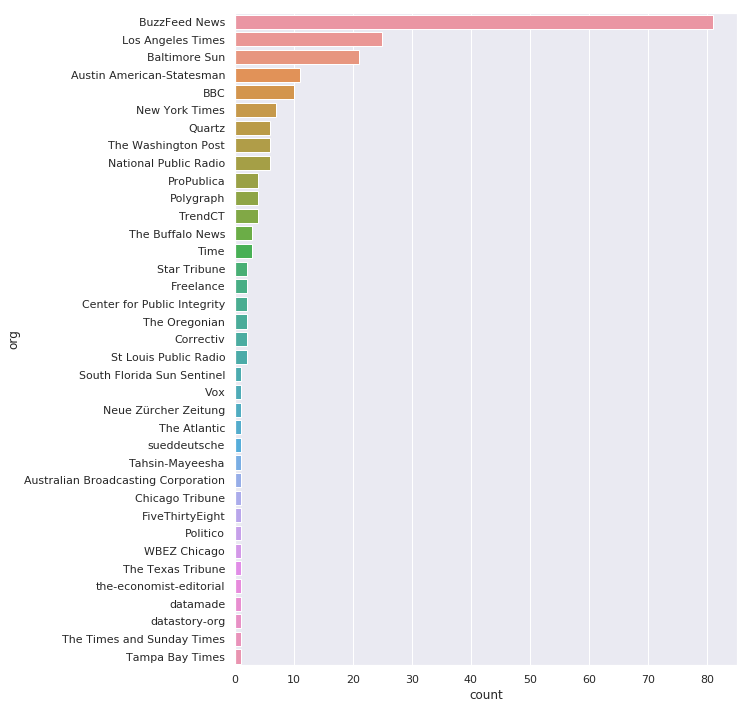

In [22]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org',
              data=repos[repos.is_keeper],
              order=repos[repos.is_keeper].org.value_counts().index) # Plot in descending order

However, one limitation of using repo count is that some organizations, such as *FiveThirtyEight* keep computational notebooks for multiple data journalism articles in one repo.

A *commit* can be thought of as the atomic unit of change for a repo. Thus the more a repo has changed overtime, the more commits it will have. Therefore, if a news organization is only using one repo for all their data journalism work, then it should have lots of commits. 

I've mined commit totals for each repo by contributor to use contributor data later in this analysis.

In [23]:
contributorsCache = 'cache/contributor_results.csv'

In [24]:
contributors = []
def getContributors(kwargs):
    """ """
    url = 'https://api.github.com/repos/{owner}/{repo}/contributors'.format(**kwargs)
    res = pingGitHub(url)
    return res if res != None else []

if not os.path.exists(contributorsCache):
    for i, row in repos[(repos.is_keeper == True) & (repos.source == 'github')].iterrows():
        is_success=False
        while not is_success:
            prompt('Finding contributors in {}'.format(row.url))
            try:
                contributors += [
                    {'login': c['login'],
                     'url': row.url,
                     'commits': c['contributions']
                    } for c in getContributors(row.to_dict())
                ]
                is_success = True
            except RateLimitError as err:
                prompt(err.message)
                time.sleep(err.timeout)

    pd.DataFrame.from_dict(contributors).to_csv(contributorsCache, index=False)
    prompt('⌛ Wrote results to {}'.format(contributorsCache))

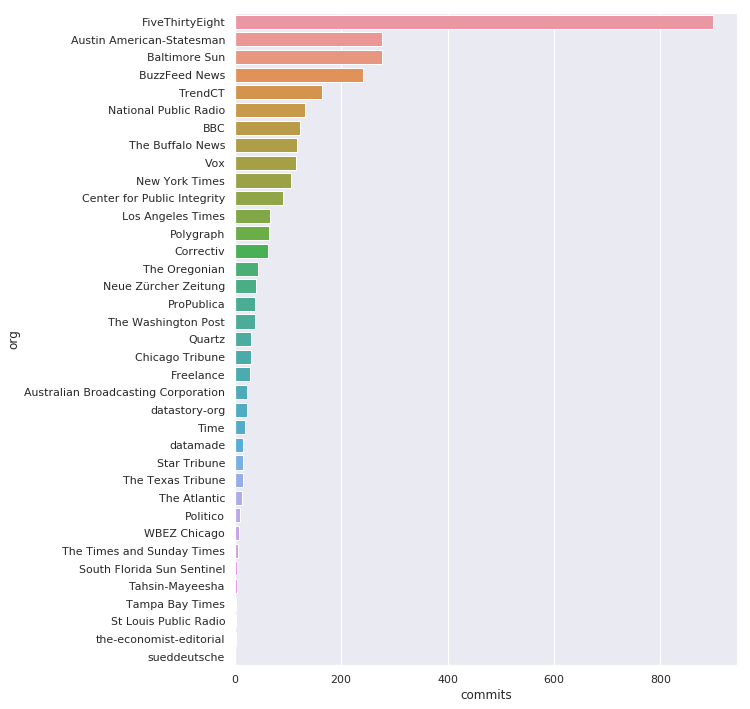

In [25]:
contributors = pd.read_csv(contributorsCache)
contributors = pd.merge(contributors, repos, on='url', how='left')

sns.barplot(x='commits', 
            y='org', 
            data=contributors.groupby('org')['commits'].sum().to_frame('commits').reset_index() \
            .sort_values('commits', ascending=False) \
            .head(50))